In [1]:
import os
import sys
p = '..'
while not os.path.isdir(p + '/notebooks'):
    p += '/..'
sys.path.append(p) # for import src

import os
import cloudpickle
import lzma
import pandas as pd
import numpy as np
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_predict
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import lightgbm as lgb
import talib
import joblib

import src
from src.ml_utils import (
    fetch_ohlcv, 
    visualize_result, 
    normalize_position, 
    calc_position_cv2,
    get_feature_columns,
    get_symbols,
    unbiased_rank,
    ewm_finite,
)
cloudpickle.register_pickle_by_value(src) # for model portability

os.environ["USE_JOBLIB_MEMORY"] = "1"

def get_joblib_memory():
    if os.getenv('USE_JOBLIB_MEMORY'):
        return joblib.Memory('/tmp/alphapool_joblib_memory', verbose=0)
    else:
        return joblib.Memory(None, verbose=0)


In [2]:
# symbols = 'BTC,ETH'.split(',')
symbols = os.getenv('ALPHAPOOL_SYMBOLS').split(',') # 売買代金が多く、古いもの
df = fetch_ohlcv(symbols=symbols, with_target=True, price_type=None, horizon=8)
df.to_pickle('/tmp/df_horizon8_price_type_none.pkl')
display(df)

op            hi           lo  \
timestamp                 symbol                                            
2019-07-20 12:00:00+00:00 BNB        30.722500     30.772500     30.62500   
                          BTC     10564.250000  10630.000000  10525.50000   
                          ETH       225.930000    226.440000    225.51000   
                          XRP         0.327975      0.328400      0.32700   
2019-07-20 13:00:00+00:00 BNB        30.625000     30.867500     30.33500   
...                                        ...           ...          ...   
2022-11-09 12:00:00+00:00 ETH      1218.900000   1262.300000   1215.70000   
                          LINK        6.800500      6.977000      6.73900   
                          MATIC       0.940400      0.967300      0.92080   
                          SOL        18.595000     19.800000     18.06000   
                          XRP         0.375250      0.385775      0.37465   

                                            cl        volume  \
timestamp                 symbol                               
2019-07-20 12:00:00+00:00 BNB        30.625000  2.215166e+04   
                          BTC     10539.500000  1.052997e+07   
                          ETH       225.830000  0.000000e+00   
                          XRP         0.327975  0.000000e+00   
2019-07-20 13:00:00+00:00 BNB        30.562500  1.649716e+05   
...                                        ...           ...   
2022-11-09 12:00:00+00:00 ETH      1240.100000  2.558305e+08   
                          LINK        6.818500  4.735283e+06   
                          MATIC       0.938100  1.362755e+07   
                          SOL        18.985000  5.257909e+07   
                          XRP         0.379625  8.275274e+06   

                                        execution_start_at       ret  
timestamp                 symbol                                      
2019-07-20 12:00:00+00:00 BNB    2019-07-20 13:00:00+00:00  0.026612  
                          BTC    2019-07-20 13:00:00+00:00  0.034090  
                          ETH    2019-07-20 13:00:00+00:00  0.030901  
                          XRP    2019-07-20 13:00:00+00:00  0.037908  
2019-07-20 13:00:00+00:00 BNB    2019-07-20 14:00:00+00:00  0.026836  
...                                                    ...       ...  
2022-11-09 12:00:00+00:00 ETH    2022-11-09 13:00:00+00:00       NaN  
                          LINK   2022-11-09 13:00:00+00:00       NaN  
                          MATIC  2022-11-09 13:00:00+00:00       NaN  
                          SOL    2022-11-09 13:00:00+00:00       NaN  
                          XRP    2022-11-09 13:00:00+00:00       NaN  

[262038 rows x 7 columns]

In [3]:
# based on 20220910_eda

import numba
from pandas.api.types import is_float_dtype

def signed_rsi_sma(x, timeperiod=14):
    v = x.diff(1).fillna(0)
    return (v.rolling(timeperiod, 1).sum() / (1e-37 + v.abs().rolling(timeperiod, 1).sum())).clip(-1, 1)

def uniform_rank(x):
    return unbiased_rank(x)
    # count = x.transform("count")
    # rank = x.rank()
    # return (rank - 0.5) / count

def beta_mean(df, col):
    # broadcast btc value
    idx = df.index.to_frame()
    idx['symbol'] = 'BTC'
    idx = pd.MultiIndex.from_frame(idx)
    return pd.Series(df.loc[idx, col].values, index=df.index)
    
def calc_features(df, with_ret=False):
    mem = get_joblib_memory()
    return mem.cache(do_calc_features)(df, with_ret=with_ret)
    
def do_calc_features(df, with_ret=False):
    dfs = []
    for symbol, df_symbol in df.groupby('symbol'):
        dfs.append(calc_features_single(df_symbol))
    df = pd.concat(dfs).sort_index()

    beta_window = 24 * 30
    # beta_window = 24 * 7

    # df['ln_cl_diff_mean'] = df.groupby('timestamp')['ln_cl_diff'].transform('mean')
    df['ln_cl_diff_mean'] = beta_mean(df, 'ln_cl_diff')
    
    # wrong
    # df['beta'] = df.groupby('symbol')['ln_cl_diff'].transform(lambda x: x.rolling(beta_window, 1).corr(df.loc[x.index, 'ln_cl_diff_mean'])).fillna(0).clip(0.1, 2.0)

    # df['beta'] = (
    #     (df['ln_cl_diff'] * df['ln_cl_diff_mean']).groupby('symbol').transform(lambda x: x.rolling(beta_window, 1).mean())
    #     / (df['ln_cl_diff_mean'] ** 2).groupby('symbol').transform(lambda x: x.rolling(beta_window, 1).mean())
    # ).fillna(0).clip(0.1, 2.0)
    df['beta'] = 1.0
    
    dfs = [
        df,
        # df.drop(columns=get_feature_columns(df)),
    ]
    
    if with_ret:
        ret_mean = beta_mean(df, 'ret')
        dfs += [
            (uniform_rank(df.groupby('timestamp')['ret']) - 0.5).rename('ret_rank'),
            (df['ret'] - df['beta'] * ret_mean).rename('ret_beta'),
        ]
    
    for col in get_feature_columns(df):
        feature_mean = beta_mean(df, col)
        dfs += [
            # (2 * uniform_rank(df.groupby('timestamp')[col]) - 1).rename(col + '_symbolrank'),
            (df[col] - df['beta'] * feature_mean).rename(col + '_symbolbeta'),
        ]
    df = pd.concat(dfs, axis=1)
    
    # dfs = [df]
    # for col in get_feature_columns(df):
    #     if '_symbolbeta' not in col:
    #         continue
    #     dfs += [
    #         (2 * uniform_rank(df.groupby('timestamp')[col]) - 1).rename(col.replace('symbolbeta', 'symbolbtrk')),
    #     ]
    # df = pd.concat(dfs, axis=1)
    
    df = df[sorted([x for x in df.columns if is_float_dtype(df.dtypes[x])])].copy().astype('float32')

    return df

def calc_features_single(df):
    df = df.copy()

    high = df['hi']
    low = df['lo']
    close = df['cl']
    volume = df['volume']
    df['ln_cl'] = np.log(df['cl'])
    df['ln_hi'] = np.log(df['hi'])
    df['ln_lo'] = np.log(df['lo'])
    df['ln_hilo'] = 0.5 * (df['ln_hi'] + df['ln_lo'])
    df['ln_cl_diff'] = df['ln_cl'].diff(1).fillna(0)
    df['ln_volume'] = np.log1p(df['volume'])

    dfs = [df]
    
    # for i in range(1, 96):
    # for i in range(1, 96 // 4):
    for i in range(1, 96 // 8):
    # for i in range(1, 192 // 8):
        dfs += [
            # (df['ln_cl'] - df['ln_cl'].rolling(8 * i).mean()).fillna(0).rename('feature_{:02}_ln_cl_kairi'.format(i)), # good
            # df['ln_cl'].diff(8).shift(i * 8).fillna(0).rename('feature_ln_cl_diff_{:02}'.format(i)),
            df['ln_cl'].diff(8 * i).fillna(0).rename('feature_{:02}_ln_cl_diff'.format(i)), # good
            # df['ln_cl'].diff(1 * i).fillna(0).rename('feature_{:02}_ln_cl_diff'.format(i)),
            # df['ln_cl'].diff(4 * i).fillna(0).rename('feature_{:02}_ln_cl_diff'.format(i)),
            # df['ln_cl'].rolling(8 * i).std().fillna(0).rename('feature_{:02}_ln_cl_std'.format(i)),
            # df['ln_volume'].diff(8 * i).fillna(0).rename('feature_{:02}_ln_volume_diff'.format(i)),
            # df['ln_volume'].rolling(8 * i).mean().fillna(0).rename('feature_{:02}_ln_volume_mean'.format(i)),
            # np.log1p(df['volume'].rolling(8 * i).mean()).fillna(0).rename('feature_{:02}_ln_volume_mean2'.format(i)),
            # signed_rsi_sma(df['cl'], timeperiod=i).fillna(0).rename('feature_{:02}_rsi'.format(i)),
        ]

    return pd.concat(dfs, axis=1)

In [4]:
import tensorflow as tf
from tensorflow.keras.layers import (
    Input, Dense, Dropout, Reshape, Conv1D, Conv2D, Conv3D, Flatten, MaxPooling1D, AveragePooling1D,
    BatchNormalization, Concatenate, Activation, Rescaling, Add, Subtract, Lambda,
    GlobalMaxPooling1D, GlobalAveragePooling1D
)
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Nadam, SGD, Adam
from tensorflow.keras import regularizers
from tensorflow.keras import initializers
from scipy.stats import norm
from scikeras.wrappers import KerasRegressor
from functools import partial
import tensorflow_addons as tfa

2022-11-09 13:36:57.567718: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-09 13:36:57.995107: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-11-09 13:36:57.995178: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-11-09 13:36:58.065550: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-11-09 13:37:00.462900: W tensorflow/stream_executor/platform/de

In [5]:
from tensorflow.python.ops import gen_math_ops, nn_ops

class GaussianDropConnectDense(Dense):
    def build(self, input_shape):
        super().build(input_shape)
        
        self.kernel_initial = self.kernel.numpy()
        # print(self.kernel_initial)
        
#         self.kernel_old = self.kernel
#         self.bias_old = self.bias
        
        
        
#         self.kernel = self.kernel_old
#         self.bias = self.bias_old * tf.keras.backend.random_normal(
#             shape=tf.shape(self.bias_old),
#             mean=1.0,
#             stddev=sigma,
#             dtype=self.bias_old.dtype,
#             seed=None
#         )
    
    def call(self, inputs, training=None):     
        # dropout_rate = 0.3   
        dropout_rate = 0.5      
        # dropout_rate = 0.7
        sigma = np.sqrt(dropout_rate / (1.0 - dropout_rate))
        
        # kernel = self.kernel_initial + tf.keras.backend.dropout(self.kernel - self.kernel_initial, dropout_rate, seed=None) / (1.0 - dropout_rate)
        kernel = self.kernel_initial + (self.kernel - self.kernel_initial) * tf.keras.backend.random_normal(
            shape=tf.shape(self.kernel),
            mean=1.0,
            stddev=sigma,
            dtype=self.kernel.dtype,
            seed=None
        )
        bias = self.bias
        
        # kernel = self.kernel * tf.keras.backend.random_normal(
        #     shape=tf.shape(self.kernel),
        #     mean=1.0,
        #     stddev=sigma,
        #     dtype=self.kernel.dtype,
        #     seed=None
        # )
        # bias = self.bias * tf.keras.backend.random_normal(
        #     shape=tf.shape(self.bias),
        #     mean=1.0,
        #     stddev=sigma,
        #     dtype=self.bias.dtype,
        #     seed=None
        # )
        
        kernel = tf.keras.backend.in_train_phase(kernel, self.kernel, training=training)
        bias = tf.keras.backend.in_train_phase(bias, self.bias, training=training)
        
        if inputs.dtype.base_dtype != self._compute_dtype_object.base_dtype:
          inputs = math_ops.cast(inputs, dtype=self._compute_dtype_object)

        rank = inputs.shape.rank
        if rank == 2 or rank is None:
            outputs = gen_math_ops.MatMul(a=inputs, b=kernel)
        # Broadcast kernel to inputs.
        else:
          outputs = standard_ops.tensordot(inputs, kernel, [[rank - 1], [0]])
          # Reshape the output back to the original ndim of the input.
          if not context.executing_eagerly():
            shape = inputs.shape.as_list()
            output_shape = shape[:-1] + [kernel.shape[-1]]
            outputs.set_shape(output_shape)

        if self.use_bias:
          outputs = nn_ops.bias_add(outputs, bias)

        if self.activation is not None:
          outputs = self.activation(outputs)
        return outputs

In [6]:
class WeightLenCallback(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs=None):
        self.initial_weights = self.model.get_weights()
        self.initial_weights_norm = self._calc_dist(self.initial_weights)
        self.prev_weights = self.initial_weights
        self.weight_len = 0.0

    def on_epoch_end(self, epoch, logs=None):
        weights = self.model.get_weights()
        weight_dist = self._calc_dist(self.initial_weights, weights)
        weight_dist2 = self._calc_dist(self.initial_weights, weights, True)
        logs['weight_dist'] = weight_dist
        # logs['weight_dist2'] = weight_dist2
        logs['weight_len'] = self.weight_len
        logs['weight_ndist'] = weight_dist / self.initial_weights_norm
        logs['weight_nlen'] = self.weight_len / self.initial_weights_norm

    def on_train_batch_end(self, batch, logs=None):
        weights = self.model.get_weights()
        self.weight_len += self._calc_dist(self.prev_weights, weights)
        self.prev_weights = weights
        
    def _calc_dist(self, w1, w2=None, normalized=False):
        d = 0.0
        for i in range(len(w1)):
            x = w1[i]
            y = w1[i] if w2 is None else w2[i] 
            if normalized:
                x = x / (1e-37 + np.sum(x ** 2) ** 0.5)
                y = y / (1e-37 + np.sum(y ** 2) ** 0.5)
            if w2 is None:
                d += np.sum(x ** 2)
            else:
                d += np.sum((x - y) ** 2)
        return d ** 0.5

In [7]:
# support multi dimension
class MyVotingRegressor:
    def __init__(self, models):
        self._models = models
        
    def fit(self, X, y, sample_weight=None):
        for label, m in self._models:
            m.fit(X, y, sample_weight=sample_weight)
        return self
        
    def predict(self, X):
        ys = []
        for label, m in self._models:
            ys.append(m.predict(X))
        return np.mean(ys, axis=0)

In [8]:
class LambdaTrain(Lambda):    
    def call(self, inputs, training=None):     
        return tf.keras.backend.in_train_phase(super().call(inputs), inputs, training=training)

In [9]:
import tempfile

class SimpleKerasPredictor:
    def __init__(self, model):
        # self.model = model
        
        converter = tf.lite.TFLiteConverter.from_keras_model(model)
        converter.optimizations = [tf.lite.Optimize.DEFAULT]
        self.tflite_data = converter.convert()
        
    def predict(self, X):
        if True:
            interpreter = tf.lite.Interpreter(model_content=self.tflite_data)
            signatures = interpreter.get_signature_list()
            # print(signatures)

            input_name = signatures['serving_default']['inputs'][0]
            output_name = signatures['serving_default']['outputs'][0]
            # {'serving_default': {'inputs': ['input_14'], 'outputs': ['activation_13']}}

            sig = interpreter.get_signature_runner()
            # print(sig)
            return sig(**{ input_name: X })[output_name]
        else:
            return self.model.predict(X)
    
    def __getstate__(self):
        state = {}
        state['tflite_data'] = self.tflite_data
        # with tempfile.TemporaryDirectory() as dir:
        #     filename = dir + '/model.h5'
        #     self.model.save(filename, include_optimizer=False)
        #     with open(filename, 'rb') as f:
        #         state['model'] = f.read()
        return state
        
    def __setstate__(self, state):
        self.tflite_data = state['tflite_data']
        # interpreter = tf.lite.Interpreter(model_content=self.tflite_data)
        # self.sig = interpreter.get_signature_runner()

        # with tempfile.TemporaryDirectory() as dir:
        #     model_data = state.get('model')
        #     filename = dir + '/model.h5'
        #     with open(filename, 'wb') as f:
        #         f.write(model_data)
        #     self.model = tf.keras.models.load_model(filename)    

In [10]:

from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import BaggingRegressor, VotingRegressor

from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.cluster import FeatureAgglomeration
import xgboost as xgb
from sklearn.ensemble import HistGradientBoostingRegressor, BaggingRegressor
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.compose import TransformedTargetRegressor
from sklearn.preprocessing import QuantileTransformer
from sklearn.feature_selection import SelectPercentile, mutual_info_regression
from sklearn.linear_model import RidgeCV

class ExampleModelRank:
    def __init__(self, ensemble=10):
        # self._model = Ridge(fit_intercept=False, alpha=1e20)
        # self._model = Pipeline([
        #     ('ss', StandardScaler()),
        #     ('model', self._model)
        # ])
        
        # self._model = lgb.LGBMRegressor(
        #     n_estimators=1000,
        #     learning_rate=0.01,
        #     extra_trees=True,
        #     # colsample_bytree=0.9,
        #     colsample_bytree=0.03,
        #     # lambda_l2=1e1,
        #     random_state=1,
        #     n_jobs=-1,
        # )
        
        # self._model = lgb.LGBMClassifier(
        #     # n_estimators=1000,
        #     # learning_rate=0.001,
        #     random_state=1,
        #     n_jobs=-1,
        # )
        
        
        # union = FeatureUnion([
        #     ("pt", 'passthrough'),
        #     ("pca", PCA(n_components=32)),
        #     ("svd", TruncatedSVD(n_components=32)),
        #     ("agg", FeatureAgglomeration(n_clusters=32)),
        # ])
        # self._model = Pipeline([
        #     # ('feat_agglo', FeatureAgglomeration(n_clusters=64)),
        #     ('union', union),
        #     ('model', self._model)
        # ])
        
        
        self.max_data_sec = 2 * 30 * 24 * 60 * 60 # for predict script
        self.price_type = None
        self.ensemble = ensemble
        self.horizon = 8

    def fit(self, df):
        df = self._calc_features(df)
        features = get_feature_columns(df)
        
        df['ret_train'] = df['ret']
        # df['ret_train'] = (df.groupby('symbol')['ln_cl'].shift(-24) - df['ln_cl']).fillna(0)
        # df['ret_train'] = (df.groupby('symbol')['ln_cl'].shift(-4) - df['ln_cl']).fillna(0)
        # df['ret_train'] = (df.groupby('symbol')['ln_hilo'].shift(-24) - df['ln_hilo']).fillna(0)
        # df['ret_train'] = (df.groupby('symbol')['ln_hilocl'].shift(-24) - df['ln_hilocl']).fillna(0)
        # df['ret_train'] = (df.groupby('symbol')['ln_hilo'].shift(-24) - df.groupby('symbol')['ln_hilo'].shift(12)).fillna(0)
        # df['ret_train'] = (df.groupby('symbol')['ln_hilo'].shift(-48) - df['ln_hilo']).fillna(0)
        # def calc_ret(x):
        #     hi = df.loc[x.index, 'hi']
        #     lo = df.loc[x.index, 'lo']
        #     return 0.5 * (hi.rolling(24, 1).max().shift(-24) + lo.rolling(24, 1).min().shift(-24)) / x - 1
        # df['ret_train'] = df.groupby('symbol')['cl'].transform(calc_ret)
        
        # df['ret_rank'] = unbiased_rank(df.groupby('timestamp')['ret_train']) - 0.5
        # df['ret_mean'] = df.groupby('timestamp')['ret_train'].transform('mean')
        df['ret_mean'] = beta_mean(df, 'ret_train')
        df['ret_beta'] = df['ret_train'] - df['ret_mean'] * df['beta']
        df = df.dropna()
        self.symbols = get_symbols(df) # for predict script
        
        df = df.loc[df.index.get_level_values('symbol') != 'BTC']
        
        print('fit df.shape', df.shape)
        
        reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
            monitor="val_loss",
            factor=0.5,
            patience=5,
            # verbose=0,
            # mode="auto",
            # min_delta=0.0001,
            # cooldown=0,
            # min_lr=0,
        )
        
        es = tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            # monitor='val_mse_weighted',
            min_delta=0,
            # patience=10,
            patience=40,
            verbose=0,
            mode='auto',
            # mode='max',
            baseline=None,
            restore_best_weights=True
        )
        
        tb = tf.keras.callbacks.TensorBoard(
            log_dir="tb_logs",
            histogram_freq=1,
            write_graph=True,
            write_images=False,
            write_steps_per_second=False,
            update_freq="epoch",
            profile_batch=0,
            embeddings_freq=1,
            embeddings_metadata=None,
        )

        # lr1 = 0.002
        lr1 = 0.002 * 1e-1
        lr0 = lr1 * 1e-2
        def scheduler(epoch, lr):
            if epoch <= 10:
                t = epoch / 10.0
            else:
                t = 1.0
            return np.exp(np.log(lr0) * (1 - t) + np.log(lr1) * t)
        
        # self._model = KerasRegressor(
        #     model=partial(build_keras_model, len(features) * 2 + 20 + 20 - 100 * 0, 0),
        #     # model=partial(build_keras_model, len(features) * 1, 0),
        #     random_state=1,
        #     # random_state=np.random.RandomState(1),
        #     # epochs=1,
        #     # epochs=4,
        #     # epochs=20,
        #     epochs=1000,
        #     validation_split=0.3, # worse than not using val
        #     callbacks=[
        #         es,
        #         # reduce_lr,
        #         # tf.keras.callbacks.LearningRateScheduler(scheduler),
        #         WeightLenCallback(),
        #         # WeightShuffleCallback(),
        #         tb, # last
        #     ],
        #     # batch_size=4096 // 8 // 8,
        #     # batch_size=4096 // 8,
        #     batch_size=4096,
        #     # batch_size=65536,
        #     # batch_size=df.shape[0],
        #     # shuffle=False,
        #     verbose=2,
        #     warm_start=True,
        # )
        # keras_model = self._model
        
        models = []
        for i in range(0, self.ensemble):
            models.append(['nn{}'.format(i), KerasRegressor(
                # model=partial(build_keras_model, len(features) * 2 + 20 + 20 - 100 * 0, i),
                model=partial(build_keras_model, len(features) * 1, i),
                epochs=1000,
                validation_split=0.3, # worse than not using val
                callbacks=[
                    es,
                    # WeightLenCallback(),
                    tb, # last
                ],
                # batch_size=4096 * 8,
                batch_size=4096,
                # batch_size=4096 // 8,
                random_state=i,
                verbose=2 if self.ensemble <= 1 else 0,
            )])
        self._model = MyVotingRegressor(models)
        
        # self._model = BaggingRegressor(self._model, random_state=1)

        nonstationary_est = lgb.LGBMRegressor(
            n_estimators=1000,
            learning_rate=0.01,
            extra_trees=True,
            colsample_bytree=0.03,
            random_state=1,
            n_jobs=-1,
        )
        
        def scale_func(x):
            return x * 0.1
        
        qt_n = 100
        
        self._model = Pipeline([
            # ('qt', QuantileTransformer(n_quantiles=qt_n, output_distribution='normal', random_state=1)),
            # ('qt', QuantileTransformer(output_distribution='uniform', random_state=1)),
            # ('sc', StandardScaler(with_mean=False)),
            ('sc', StandardScaler()),
            # ('fu', FeatureUnion([ # not good?
            #     ('pt', 'passthrough'),
            #     ('qt', QuantileTransformer(n_quantiles=qt_n, output_distribution='normal', random_state=1)),
            #     ('pca', PCA(20, whiten=True)), # good?
            #     # ('fa', FeatureAgglomeration(20, pooling_func=np.median)), # not good?
            #     ('fa_std', Pipeline([ # not bad?
            #         ('fa_std2', FeatureAgglomeration(20, pooling_func=np.std)),
            #         ('qt2', QuantileTransformer(n_quantiles=qt_n, output_distribution='normal', random_state=1)),
            #     ])),
            # ])),
            # ('scale', FunctionTransformer(scale_func)),
            # ('pca', PCA(whiten=True)), # bad
            ('model', self._model)
        ])
        
        # self._model = Ridge(alpha=1e5, fit_intercept=False)
        # self._model = RidgeCV(fit_intercept=False)
        
        # dfs = []
        # for i in range(4):
        #     df2 = df.copy()
        #     df2[features] = df2[features] + np.random.normal(0, 0.1, (df.shape[0], len(features)))
        #     dfs += [
        #         df2
        #     ]
        # df = pd.concat(dfs)
        
        # df[features] += np.random.normal(0, 0.1, (df.shape[0], len(features)))
        
        sw = np.abs(df['ret_beta'])
        # sw = np.abs(df['ret'])
        sw /= np.mean(sw)
        # sw[:] = 1.0
        # sw += 1e-2
        # sw /= pd.Series(sw).rolling(1000, 1).mean().iloc[::-1].rolling(1000, 1).mean().iloc[::-1].values
        # sw /= np.mean(sw)
        
        X = df[features]
        y = np.sign(df['ret_beta'])
        # y = np.sign(df['ret'])
        # y = (df['ret_beta'] >= 0) * 1.0
        # y = df['ret_beta']
        # y = df['ret_beta'] / df['ret_beta'].std()
        
        # for i in range(20):
        # #     # batch_size = int(32 * 2.0 ** i)
        # #     # batch_size = 32
        #     batch_size = 4096
        #     # batch_size = df.shape[0]
        #     # self._model._random_state = i
        #     self._model.partial_fit(X, y, sample_weight=sw, batch_size=batch_size)
        # #     # self._model.partial_fit(X, y, batch_size=batch_size)
        # #     if es.stopped_epoch > 0:
        #         # break
        
        # self._model.fit(X, y, sample_weight=sw)
        
        for i in range(0):
            # es.patience = 400
            # es.restore_best_weights = True
            # es.monitor = 'loss'
            
            self._model.fit(X, y, model__sample_weight=sw, model__epochs=4)

            weights = keras_model.model_.get_weights()
            for i in range(0, len(weights)):
            # for i in range(len(weights) // 2, len(weights)):
                w = weights[i]
                if False:
                # if len(w.shape) == 1:
                    w[:] = 0.0
                else:
                    # flatten shuffle
                    w = np.random.permutation(w.flatten()).reshape(w.shape)
                    # axis 0 shuffle
                    # w = np.random.permutation(w)
                    # axis 1 shuffle 
                    # maybe overfit
                    # if len(w.shape) == 2:
                    #     w = np.random.permutation(w.T).T
                    # else:
                    #     w = np.random.permutation(w)
                weights[i] = w

            keras_model.model_.set_weights(weights)
        
        es.monitor = 'val_loss'
        # es.monitor = 'val_cosine_similarity'
        # es.patience = 10
        # es.restore_best_weights = True
        self._model.fit(X, y, model__sample_weight=sw)
        
        # converter = tf.lite.TFLiteConverter.from_keras_model(self._model.named_steps['model'].model_)
        # converter.optimizations = [tf.lite.Optimize.DEFAULT]
        # self._model.named_steps['model'].model_ = converter.convert()
        
        # return self._model.fit(df[features], df['ret_beta'])
        # self._model.fit(df[features], np.sign(df['ret_beta']), model__sample_weight=sw)
        # return self._model.fit(df[features], df['ret_rank'])
        # return self._model.fit(df[features], np.sign(df['ret_rank']), sample_weight=np.abs(df['ret_rank']))
        # return self._model.fit(df[features], np.sign(df['ret_rank']), model__sample_weight=np.abs(df['ret_rank']))
        
        models = self._model.named_steps['model']._models
        for i in range(len(models)):
            models[i][1] = SimpleKerasPredictor(models[i][1].model_)
    
    def predict(self, df):
        df = self._calc_features(df)
        features = get_feature_columns(df)
        y_pred = self._model.predict(df[features]).flatten()
        
        if os.getenv('USE_JOBLIB_MEMORY'):
            corrs = df[features].corrwith(pd.Series(y_pred, index=df.index))
            plt.plot(corrs.sort_values().values)
            # corrs = df[features].rank().corrwith(pd.Series(y_pred, index=df.index).rank())
            # plt.plot(corrs.sort_values().values)
            plt.show()
        
        # df['position'] = np.sign(y_pred)
        df['position'] = y_pred
        # df['position'] -= 0.5
        idx_btc = df.index.get_level_values('symbol') == 'BTC'
        df.loc[idx_btc, 'position'] = 0
        # df['position'] = unbiased_rank(df.groupby('timestamp')['position']) - 0.5
        
        # df['position_beta'] = df['position'] * df['beta']
        # df['position_btc'] = -df.groupby('timestamp')['position_beta'].transform('sum')
        # df.loc[idx_btc, 'position'] = df.loc[idx_btc, 'position_btc']
        
        # df['position'] = df.groupby('symbol')['position'].transform(lambda x: calc_pos(x, 0.4))
        
        normalize_position(df)
        return df['position']
    
    def _calc_features(self, df):
        df = df.copy()
        df = calc_features(df)
        
        # dfs = [df]
        # for col in get_feature_columns(df):
        #     dfs += [
        #         (df[col] ** 2).rename(col + '_sqr'),
        #     ]
        # df = pd.concat(dfs, axis=1)
        
        return df

class SparseConstraint(tf.keras.constraints.Constraint):
    def __init__(self, mask):
        self.mask = mask
        self.mask_t = tf.convert_to_tensor(mask)

    def __call__(self, w):
        return w * self.mask_t

    def get_config(self):
        return {'mask': self.mask}


# 1dcnn https://www.keep-current.dev/convolution-networks-on-tabular-data/
# tanh, mae: https://github.com/hoseinzadeehsan/CNNpred-Keras
def build_keras_model(input_size, idx=0):
    inputs = Input(shape=(input_size,))
    x = inputs
    # x = Dropout(0.5)(x)
    
    class DistanceL2(tf.keras.regularizers.Regularizer):
        def __init__(self, l2=0.01):
            self.l2 = tf.keras.backend.cast_to_floatx(l2)
            self.initial_x = None
            
        def __call__(self, x):
            initial_x = self.initial_x.flatten()
            diff = tf.reshape(x, (-1,)) - initial_x
            # d = tf.math.reduce_sum(diff * initial_x)
            # n = np.sum(initial_x ** 2)
            # diff = diff - initial_x * d / n
            return 2.0 * self.l2 * tf.nn.l2_loss(diff)

        def get_config(self):
            return {"l2": float(self.l2)}
        
    # l2_dist = 1e-5
    # l2_dist = 1e-4
    # l2_dist = 1e-3
    l2_dist = 0.0
    
    reg_l1 = regularizers.l1(1e-3)
    
    reg = None
    # reg = regularizers.l1(1e-5)
    # reg = regularizers.l2(1e-1)
    # reg = regularizers.l2(1e-2)
    # reg = regularizers.l2(1e-3)
    # reg = regularizers.l2(4e-3)
    # reg = regularizers.l2(1e-4)
    # reg = regularizers.l2(1e-7)
    # reg = regularizers.L1L2(
    #     l1=1e-5, 
    #     l2=1e-5,
    # )
    
    # act = 'relu'
    # act = 'tanh'
    act = 'elu' # good for cnn?
    # act = tf.keras.activations.swish
    # act = tf.keras.layers.LeakyReLU(alpha=0.1)
    # act = tf.keras.layers.PReLU()
    # act = tfa.activations.mish
    # act = 'gelu' # good?
    # act = 'softplus'
    
    # dropout_rate = 0.96
    # dropout_rate = 0.98 # good?
    dropout_rate = 0.99
    # dropout_rate = 0.995
    
    # initializer = initializers.Zeros()
    # initializer = initializers.HeNormal()
    # initializer = initializers.GlorotNormal()
    
    orth_init = initializers.Orthogonal(gain=1.0, seed=None) # bad
    
    # initializer = 'glorot_uniform'
    # initializer = 'glorot_normal'
    initializer = 'he_normal'
    # initializer = 'he_uniform'
    # initializer = orth_init
    bias_initializer = 'zeros'
    # bias_initializer = 'he_normal'
    
#     def initializer(shape, dtype=None):
#         p = 0.1
#         dropout_scale = 1.0 / (0.5 / p + 0.5 * p) ** 0.5 # https://arxiv.org/pdf/1607.02488.pdf
#         # return initializers.GlorotUniform()(shape, dtype=dtype) * 0.1 ** 0.5
#         # return initializers.GlorotNormal()(shape, dtype=dtype) * dropout_scale
#         w = initializers.HeNormal()(shape, dtype=dtype)
#         # w = initializers.Orthogonal(gain=1.0, seed=None)(shape, dtype=dtype)
#         # w = w ** 3 # 3 is good
#         w /= tf.reduce_mean(w ** 2) ** 0.5
#         print(shape)
#         n_in, n_out = shape
#         # w /= n_in ** 0.5
#         # w /= n_out ** 0.5 # good
        
#         # https://arxiv.org/pdf/1902.06853.pdf
#         w /= n_in ** 0.5
#         # w *= 1.3
#         # w *= 0.9
#         return w
    
#     def bias_initializer(shape, dtype=None):
#         w = initializers.HeNormal()(shape, dtype=dtype)
#         w /= tf.reduce_mean(w ** 2) ** 0.5
#         return w
    
    size = 8
    # size = 12
    # kernel_size = 5
    kernel_size = int(size * 3 / 4)
    # kernel_size = int(size / 2)
    # kernel_size = size
    
    size = 32
    # size = 64
    # size = 128
    # size = 512
    # size = 1024
    
    dist_regs = []
    dist_reg_layers = []
    mars_constraints = []
    
    hidden_outputs = [x]
    
    def conv1d_mean_zero(x):
        return x - tf.math.reduce_mean(x, axis=-1, keepdims=True)
    
    # x = Reshape((23, 2))(x)
    # x = Reshape((11, 4))(x)
    # x = Reshape((95, 2))(x)
    x = Reshape((11, 2))(x)
    # x = Reshape((11, 3))(x)
    # def f1(x):
    #     x = tf.math.cumsum(x, axis=-2)
    #     # x -= tf.math.reduce_mean(x, axis=-2, keepdims=True)
    #     return x
    # x = Lambda(f1)(x)
    # x = Dropout(0.5)(x)
    x = Conv1D(
        filters=32, 
        kernel_size=5,
        # kernel_size=10,
        # kernel_size=5 * 8,
        activation=act, use_bias=True, 
        # padding='SAME',
        padding='VALID',
        kernel_regularizer=reg, 
        bias_regularizer=reg,
        kernel_initializer=initializer, 
        # bias_initializer=initializer,
        # kernel_constraint=conv1d_mean_zero, # good?
    )(x)
    # x = MaxPooling1D(2)(x)
    # x = Dropout(0.5)(x)
    x = Conv1D(
        filters=32,
        kernel_size=5,
        # kernel_size=10,
        # kernel_size=5 * 8,
        activation=act, use_bias=True, 
        # padding='SAME',
        padding='VALID',
        kernel_regularizer=reg, 
        bias_regularizer=reg,
        kernel_initializer=initializer, 
        # bias_initializer=initializer,
        # kernel_constraint=conv1d_mean_zero,
    )(x)
    # x = Dropout(0.5)(x)
    # x = Conv1D(
    #     filters=32, 
    #     kernel_size=4,
    #     activation=act, use_bias=True, 
    #     # padding='SAME',
    #     padding='VALID',
    #     kernel_regularizer=reg, 
    #     bias_regularizer=reg,
    #     kernel_initializer=initializer, 
    #     # bias_initializer=initializer,
    # )(x)
    # x = Dropout(0.5)(x)
    x = MaxPooling1D(2)(x) # good?
    # x = AveragePooling1D(2)(x)
    # x = AveragePooling1D(2)(x)
    # x = AveragePooling1D(2)(x)
    # x = GlobalMaxPooling1D()(x)
    # x = GlobalAveragePooling1D()(x)
    x = Flatten()(x)
    
#     depth = 2 + idx * 0
#     for i in range(depth):
#         t = 1.0 * i / (depth - 1)
#         x_prev = x
        
#         dist_reg = DistanceL2(l2_dist)
#         dist_regs.append(dist_reg)
#         mars_constraint = MarsConstraint(8)
#         mars_constraints.append(mars_constraint)
#         # dense = GaussianDropConnectDense(
#         dense = Dense(
#             # size,
#             # 32,
#             # 64,
#             128, # good with l2 reg
#             # 256,
#             # int(np.exp(np.log(64) * (1 - t) + np.log(64) * t)),
#             # 64 if i == 0 else 128,
#             activation=act, 
#             # activation=None,
#             use_bias=True,
#             # use_bias=False,
#             # kernel_regularizer=reg_l1, 
#             kernel_regularizer=reg,
#             # kernel_regularizer=dist_reg,
#             # kernel_regularizer=reg2,
#             bias_regularizer=reg,
#             # kernel_initializer='zeros' if i > 0 else initializer,
#             kernel_initializer=initializer, 
#             bias_initializer=bias_initializer,
#             # kernel_constraint=mars_constraint,
#             # kernel_constraint=SparseConstraint(np.random.binomial(1, 1.0 / 64, size=(input_size, size))) # bad
#         )
#         dist_reg_layers.append(dense)
#         # dense = GaussianDropConnect(dense, rate=0.2)
#         x = dense(x)
#         # x = BatchNormalization()(x)
#         # def smooth_units(x):
#         #     return (x[:, 1:] + x[:, :-1]) / 2
#         #     # return (x[:, 3:] + x[:, 2:-1] + x[:, 1:-2] + x[:, :-3]) / 4
#         # x = Lambda(smooth_units)(x)
#         # x = Activation(act)(x)
#         # x = Lambda(smooth_units)(x)
#         # if i > 0:
#         #     x = Add()([x, x_prev])
#         # if i == 9:
#         #     x = tf.keras.layers.GaussianDropout(0.5)(x)
#         # x = tf.keras.layers.GaussianDropout(dropout_rate)(x)
#         # x = Dropout(dropout_rate)(x)
#         # x = Dropout(0.1)(x)
#         # x = tf.keras.layers.GaussianDropout(0.1)(x)
        
#         hidden_outputs.append(x)

        
    # x = Concatenate()(hidden_outputs)
    
    # x = Reshape((-1, 1))(x)
    # x = AveragePooling1D(2)(x)
    # x = Flatten()(x)
    # x = Dropout(dropout_rate)(x)
    # x = tf.keras.layers.GaussianDropout(dropout_rate)(x)
    # x = tf.keras.layers.GaussianDropout(0.995)(x)
    # x = tf.keras.layers.GaussianDropout(0.9)(x)
    # x = tf.keras.layers.GaussianDropout(1.0 - 0.01 / 2 ** 0.5)(x)
    # x = tf.keras.layers.GaussianNoise(100)(x) # bad

    dist_reg = DistanceL2(l2_dist)
    dist_regs.append(dist_reg)
    # d3 = tfa.layers.NoisyDense(
    # d3 = GaussianDropConnectDense(
    d3 = Dense(
        1,
        # activation='linear',
        # activation='tanh', # good
        # activation='sigmoid',
        # use_factorised=False,
        use_bias=True, 
        # use_bias=False, 
        kernel_regularizer=reg, 
        # kernel_regularizer=dist_reg,
        # kernel_regularizer=reg3, 
        bias_regularizer=reg,
        kernel_initializer=initializer,
        # kernel_initializer='glorot_uniform',
        # kernel_initializer='zeros',
        # bias_initializer=initializer,
    )
    dist_reg_layers.append(d3)
    # d3 = GaussianDropConnect(d3, rate=0.2)
    x = d3(x)
    # x = Rescaling(0.1)(x)
    x = Rescaling(0.01)(x)
    # x = Rescaling(1 - dropout_rate)(x) # good?
    # x = Rescaling(0.04)(x)
    def scale_output_train(x):
        return x * 2.0
    x = LambdaTrain(scale_output_train)(x)
    x = Activation('tanh')(x) # good
    
    model = Model(inputs=inputs, outputs=x)
    
    def make_gc_opt(klass):
        class GCOpt(klass):
            def get_gradients(self, loss, params):
                grads = []
                gradients = super().get_gradients()
                for grad in gradients:
                    grad_len = len(grad.shape)
                    if grad_len > 1:
                        axis = list(range(grad_len - 1))
                        grad -= tf.reduce_mean(grad, axis=axis, keep_dims=True)
                    grads.append(grad)
                return grads
        return GCOpt
    
    # def _get_gradients(self, tape, loss, var_list, grad_loss=None):
    #     """Called in `minimize` to compute gradients from loss."""
    #     grads = tape.gradient(loss, var_list, grad_loss)
    #     return list(zip(grads, var_list))
    
    def make_gaussian_drop_connect_opt(klass):
        class GaussianDropConnectOpt(klass):
            def _get_gradients(self, tape, loss, var_list, grad_loss=None):
                print('BBB')
                # print(var_list)
                # drop_connect_rate = 0.9
                # sigma = np.sqrt(drop_connect_rate / (1.0 - drop_connect_rate))
                # orig_var_list = []
                # for w in var_list:
                #     orig_var_list.append(w)
                #     w.assign(w * tf.keras.backend.random_normal(
                #         shape=tf.shape(w),
                #         mean=1.0,
                #         stddev=sigma,
                #         dtype=w.dtype,
                #         seed=None
                #     ))
                #     # w2 = tf.identity(w2, name=w.name)
                #     # w2 = tf.Variable(w2, name=w.name)
                #     # print(w2)
                #     # var_list2.append(w2)
                grads = tape.gradient(loss, var_list, grad_loss)
                # print(grads)
                return list(zip(grads, var_list))
            
            def get_gradients(self, loss, params):
                print('AAA')
                grads = []
                params2 = []
                drop_connect_rate = 0.9
                sigma = np.sqrt(drop_connect_rate / (1.0 - drop_connect_rate))
                for p in params:
                    p = p * tf.keras.backend.random_normal(
                        shape=tf.shape(p),
                        mean=1.0,
                        stddev=sigma,
                        dtype=p.dtype,
                        seed=None
                    )
                    params2.append(p)
                    
                return super().get_gradients(loss, params2)
        return GaussianDropConnectOpt
        
    class AdamWNoise(tfa.optimizers.AdamW):
        def get_gradients(self, loss, params):
            grads = []
            gradients = super().get_gradients()
            for grad in gradients:
                grad += tf.random_normal(
                    shape=grad.get_shape(), 
                    mean=0.0, 
                    stddev=1e-3
                )
                grads.append(grad)
            return grads
    
    # opt = tfa.optimizers.SGDW(
        # weight_decay=1e-4,
    # opt = SGD(
    #     learning_rate=0.01 / 8,
    #     # learning_rate=0.1,
    #     # learning_rate=0.1 / 8,
    #     # learning_rate=1,
    #     momentum=1.0 - 0.1 / 8, 
    #     # nesterov=True,
    # )
    
    # opt = GCNadam(
    opt = Nadam(
        # learning_rate=0.002 * 1e-1,
        learning_rate=0.002,
        beta_1=0.9, 
        # beta_1=0.5,
        # beta_2=0.9,
        beta_2=0.999,
        epsilon=None,
        # epsilon=1e-1,
        # epsilon=1e-3,
        schedule_decay=0.004,
    )
    # opt = tfa.optimizers.AdaBelief(
    #     # learning_rate=0.001,
    #     learning_rate=0.001 / 8,
    #     # learning_rate=0.001 / 8 / 8,
    #     # learning_rate=0.001 / 8 / 8 / 8,
    #     # total_steps=1200,
    #     # warmup_proportion=0.1,
    #     # min_lr=1e-5,
    #     # rectify=True,
    #     # weight_decay=1e-2,
    #     # weight_decay=1e-3,
    #     # epsilon=1e-10,
    # )
    # opt = tfa.optimizers.Lookahead(opt)
    # opt = Adam(
    #     learning_rate=0.001,
    #     beta_1=0.9, 
    #     beta_2=0.999, 
    #     epsilon=None, 
    #     decay=0.0,
    #     # amsgrad=True
    # )
    # opt = AdamWNoise(
    # opt = tfa.optimizers.AdamW(
    # # # opt = make_gaussian_drop_connect_opt(tfa.optimizers.AdamW)(
    #     learning_rate=0.002,
    #     # learning_rate=0.002 * 1e-1,
    #     # learning_rate=0.001 * 1e-1,
    #     # learning_rate=0.002 * 1e-2,
    #     # weight_decay=1e-2,
    #     weight_decay=1e-3,
    #     # weight_decay=1e-4,
    #     # weight_decay=1e-5,
    #     # weight_decay=1e-7,
    #     # beta_1=0.1,
    # )
    
    def my_loss_fn(y_true, y_pred):
        # return tf.reduce_mean(tf.square(tf.sign(y_true) - y_pred) * tf.abs(y_true))
        # return -tf.reduce_mean(y_pred * y_true) / (1e-37 + tf.reduce_mean(y_pred ** 2) ** 0.5) # good
        # return -tf.reduce_mean(y_pred * y_true) / (1e-37 + tf.reduce_mean(tf.abs(y_pred))) # bad
        # ret = tf.reduce_sum(y_pred * y_true, axis=-1)
        # ret /= 1e-37 + tf.reduce_sum(tf.abs(y_pred), axis=-1)
        # return tf.reduce_mean(-ret + ret ** 2)
        
        ret = y_pred * y_true
        sharpe = tf.reduce_mean(ret) / (tf.reduce_mean(ret ** 2) ** 0.5)
        return -sharpe
        # return -sharpe + sharpe ** 2
        
        # p = (y_pred * 0.999 + 1) / 2
        # one_true_p = tf.where(y_true == 1, 0.8, 0.0)
        # zero_true_p = 1.0 - one_true_p
        # return -one_true_p * tf.math.log(p) - zero_true_p * tf.math.log(1 - p)
        # return (y_true - y_pred) ** 2
    
    model.compile(
        optimizer=opt,
        loss='mse', # good for sign ret
        # loss='logcosh', # good for raw ret
        # loss='mae', # good for raw ret
        # loss=my_loss_fn,
        # loss='binary_crossentropy',
        # loss='hinge',
        # loss='squared_hinge',
        # loss='cosine_similarity',
        metrics=[
            'mse',
            # 'accuracy',
        ],
        weighted_metrics=[
            'mse',
            'cosine_similarity',
            # 'logcosh',
            # tfa.metrics.RSquare(),
        ]
    )
    
    for i, dist_reg in enumerate(dist_regs):
        dist_reg.initial_x = dist_reg_layers[i].get_weights()[0]
    for i, mars_constraint in enumerate(mars_constraints):
        mars_constraint.initial_weight = dist_reg_layers[i].get_weights()[0]
    
    # reg_cnn1.initial_x = cnn1.get_weights()[0]
    # reg_cnn2.initial_x = cnn2.get_weights()[0]
    # reg_cnn3.initial_x = cnn3.get_weights()[0]
    # reg1.initial_x = d1.get_weights()[0]
    # reg2.initial_x = d2.get_weights()[0]
    # reg3.initial_x = d3.get_weights()[0]
    
    return model

float32
fit df.shape (201190, 39)


2022-11-09 13:37:21.260790: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-11-09 13:37:21.260852: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2022-11-09 13:37:21.260885: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ec65dac88a5e): /proc/driver/nvidia/version does not exist
2022-11-09 13:37:21.261274: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


INFO:tensorflow:Assets written to: /tmp/tmp0841tz05/assets


INFO:tensorflow:Assets written to: /tmp/tmp0841tz05/assets
2022-11-09 13:42:42.176367: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-09 13:42:42.176470: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-09 13:42:42.177545: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp0841tz05
2022-11-09 13:42:42.180255: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-09 13:42:42.180314: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp0841tz05
2022-11-09 13:42:42.203451: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:354] MLIR V1 optimization pass is not enabled
2022-11-09 13:42:42.205720: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-09 13:42:42.276532: I tensorflow/cc/saved_model/loader.cc:213] Running initializatio

INFO:tensorflow:Assets written to: /tmp/tmpd9f23zpy/assets


INFO:tensorflow:Assets written to: /tmp/tmpd9f23zpy/assets
2022-11-09 13:42:44.300353: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-09 13:42:44.300453: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-09 13:42:44.300678: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpd9f23zpy
2022-11-09 13:42:44.303616: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-09 13:42:44.303673: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpd9f23zpy
2022-11-09 13:42:44.316872: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-09 13:42:44.383970: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpd9f23zpy
2022-11-09 13:42:44.401525: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp5kz0c2zg/assets


INFO:tensorflow:Assets written to: /tmp/tmp5kz0c2zg/assets
2022-11-09 13:42:47.332499: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-09 13:42:47.332596: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-09 13:42:47.332837: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp5kz0c2zg
2022-11-09 13:42:47.338802: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-09 13:42:47.338875: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp5kz0c2zg
2022-11-09 13:42:47.360946: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-09 13:42:47.454935: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp5kz0c2zg
2022-11-09 13:42:47.486826: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpo_s8b6y6/assets


INFO:tensorflow:Assets written to: /tmp/tmpo_s8b6y6/assets
2022-11-09 13:42:49.564139: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-09 13:42:49.564245: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-09 13:42:49.564470: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpo_s8b6y6
2022-11-09 13:42:49.567236: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-09 13:42:49.567305: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpo_s8b6y6
2022-11-09 13:42:49.576076: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-09 13:42:49.649249: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpo_s8b6y6
2022-11-09 13:42:49.669535: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp2h4m5akm/assets


INFO:tensorflow:Assets written to: /tmp/tmp2h4m5akm/assets
2022-11-09 13:42:51.630250: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-09 13:42:51.630339: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-09 13:42:51.630575: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp2h4m5akm
2022-11-09 13:42:51.632849: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-09 13:42:51.632891: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp2h4m5akm
2022-11-09 13:42:51.640407: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-09 13:42:51.708628: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp2h4m5akm
2022-11-09 13:42:51.728153: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp6w7h6p4l/assets


INFO:tensorflow:Assets written to: /tmp/tmp6w7h6p4l/assets
2022-11-09 13:42:53.696739: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-09 13:42:53.696838: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-09 13:42:53.697067: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp6w7h6p4l
2022-11-09 13:42:53.699331: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-09 13:42:53.699379: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp6w7h6p4l
2022-11-09 13:42:53.706797: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-09 13:42:53.768125: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp6w7h6p4l
2022-11-09 13:42:53.785567: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpv96auz7b/assets


INFO:tensorflow:Assets written to: /tmp/tmpv96auz7b/assets
2022-11-09 13:42:55.652276: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-09 13:42:55.652366: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-09 13:42:55.652598: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpv96auz7b
2022-11-09 13:42:55.654876: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-09 13:42:55.654925: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpv96auz7b
2022-11-09 13:42:55.663344: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-09 13:42:55.725364: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpv96auz7b
2022-11-09 13:42:55.742027: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmplu77h3fn/assets


INFO:tensorflow:Assets written to: /tmp/tmplu77h3fn/assets
2022-11-09 13:42:57.577519: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-09 13:42:57.577613: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-09 13:42:57.577831: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmplu77h3fn
2022-11-09 13:42:57.580001: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-09 13:42:57.580051: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmplu77h3fn
2022-11-09 13:42:57.587114: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-09 13:42:57.648851: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmplu77h3fn
2022-11-09 13:42:57.665380: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp0f9omsos/assets


INFO:tensorflow:Assets written to: /tmp/tmp0f9omsos/assets
2022-11-09 13:42:59.592353: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-09 13:42:59.592450: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-09 13:42:59.592682: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp0f9omsos
2022-11-09 13:42:59.595108: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-09 13:42:59.595169: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp0f9omsos
2022-11-09 13:42:59.603414: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-09 13:42:59.667398: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp0f9omsos
2022-11-09 13:42:59.684153: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpxoovlqx4/assets


INFO:tensorflow:Assets written to: /tmp/tmpxoovlqx4/assets
2022-11-09 13:43:01.642485: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-09 13:43:01.642576: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-09 13:43:01.642796: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpxoovlqx4
2022-11-09 13:43:01.645029: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-09 13:43:01.645086: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpxoovlqx4
2022-11-09 13:43:01.652863: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-09 13:43:01.715413: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpxoovlqx4
2022-11-09 13:43:01.732149: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

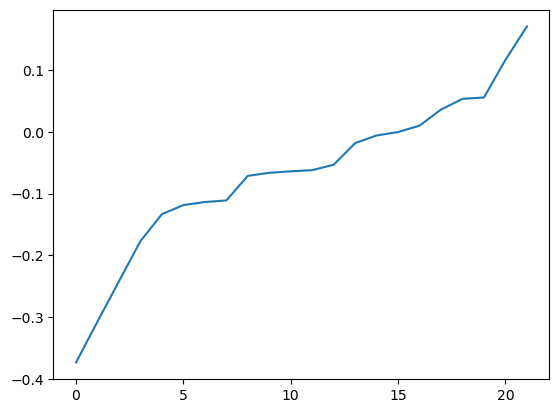

fit df.shape (186931, 39)


INFO:tensorflow:Assets written to: /tmp/tmpkrl4qve8/assets


INFO:tensorflow:Assets written to: /tmp/tmpkrl4qve8/assets
2022-11-09 13:50:12.901508: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-09 13:50:12.901612: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-09 13:50:12.901845: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpkrl4qve8
2022-11-09 13:50:12.904176: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-09 13:50:12.904232: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpkrl4qve8
2022-11-09 13:50:12.912193: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-09 13:50:12.978645: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpkrl4qve8
2022-11-09 13:50:12.997982: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpuxip85q6/assets


INFO:tensorflow:Assets written to: /tmp/tmpuxip85q6/assets
2022-11-09 13:50:14.953749: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-09 13:50:14.953841: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-09 13:50:14.954085: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpuxip85q6
2022-11-09 13:50:14.956292: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-09 13:50:14.956346: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpuxip85q6
2022-11-09 13:50:14.964540: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-09 13:50:15.031680: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpuxip85q6
2022-11-09 13:50:15.048081: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp9djxv3o_/assets


INFO:tensorflow:Assets written to: /tmp/tmp9djxv3o_/assets
2022-11-09 13:50:16.970643: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-09 13:50:16.970751: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-09 13:50:16.970977: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp9djxv3o_
2022-11-09 13:50:16.973411: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-09 13:50:16.973475: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp9djxv3o_
2022-11-09 13:50:16.982088: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-09 13:50:17.050730: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp9djxv3o_
2022-11-09 13:50:17.070850: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp8y5ec2d6/assets


INFO:tensorflow:Assets written to: /tmp/tmp8y5ec2d6/assets
2022-11-09 13:50:18.994725: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-09 13:50:18.994825: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-09 13:50:18.995056: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp8y5ec2d6
2022-11-09 13:50:18.997324: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-09 13:50:18.997381: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp8y5ec2d6
2022-11-09 13:50:19.005606: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-09 13:50:19.071420: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp8y5ec2d6
2022-11-09 13:50:19.089825: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp1rg2gw0t/assets


INFO:tensorflow:Assets written to: /tmp/tmp1rg2gw0t/assets
2022-11-09 13:50:21.044135: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-09 13:50:21.044237: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-09 13:50:21.044463: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp1rg2gw0t
2022-11-09 13:50:21.046794: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-09 13:50:21.046853: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp1rg2gw0t
2022-11-09 13:50:21.054710: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-09 13:50:21.123330: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp1rg2gw0t
2022-11-09 13:50:21.142255: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmph8oipf9q/assets


INFO:tensorflow:Assets written to: /tmp/tmph8oipf9q/assets
2022-11-09 13:50:23.034007: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-09 13:50:23.034126: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-09 13:50:23.034350: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmph8oipf9q
2022-11-09 13:50:23.036674: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-09 13:50:23.036728: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmph8oipf9q
2022-11-09 13:50:23.044598: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-09 13:50:23.111927: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmph8oipf9q
2022-11-09 13:50:23.129167: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp74537qjm/assets


INFO:tensorflow:Assets written to: /tmp/tmp74537qjm/assets
2022-11-09 13:50:24.987732: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-09 13:50:24.987829: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-09 13:50:24.988075: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp74537qjm
2022-11-09 13:50:24.990615: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-09 13:50:24.990668: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp74537qjm
2022-11-09 13:50:25.001674: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-09 13:50:25.069049: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp74537qjm
2022-11-09 13:50:25.086027: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp0zpzhtpy/assets


INFO:tensorflow:Assets written to: /tmp/tmp0zpzhtpy/assets
2022-11-09 13:50:27.059158: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-09 13:50:27.059256: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-09 13:50:27.059481: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp0zpzhtpy
2022-11-09 13:50:27.062321: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-09 13:50:27.062378: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp0zpzhtpy
2022-11-09 13:50:27.079068: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-09 13:50:27.145129: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp0zpzhtpy
2022-11-09 13:50:27.161984: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpybuqpye6/assets


INFO:tensorflow:Assets written to: /tmp/tmpybuqpye6/assets
2022-11-09 13:50:29.109553: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-09 13:50:29.109655: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-09 13:50:29.109875: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpybuqpye6
2022-11-09 13:50:29.112774: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-09 13:50:29.112841: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpybuqpye6
2022-11-09 13:50:29.130438: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-09 13:50:29.199943: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpybuqpye6
2022-11-09 13:50:29.216305: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp5kpdiann/assets


INFO:tensorflow:Assets written to: /tmp/tmp5kpdiann/assets
2022-11-09 13:50:31.172592: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-09 13:50:31.172687: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-09 13:50:31.172905: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp5kpdiann
2022-11-09 13:50:31.175870: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-09 13:50:31.175919: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp5kpdiann
2022-11-09 13:50:31.192277: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-09 13:50:31.258263: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp5kpdiann
2022-11-09 13:50:31.275886: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

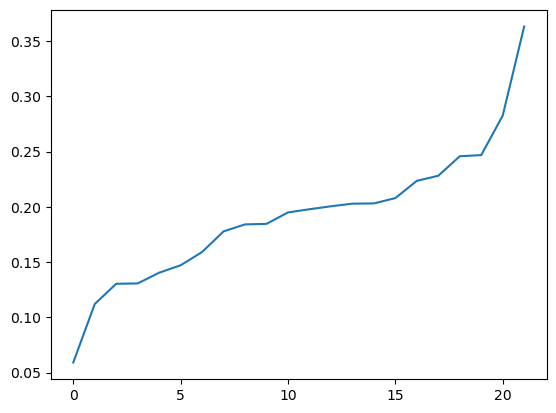

fit df.shape (179957, 39)


INFO:tensorflow:Assets written to: /tmp/tmpl1xmk3zs/assets


INFO:tensorflow:Assets written to: /tmp/tmpl1xmk3zs/assets
2022-11-09 13:57:40.216767: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-09 13:57:40.216865: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-09 13:57:40.217105: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpl1xmk3zs
2022-11-09 13:57:40.219422: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-09 13:57:40.219473: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpl1xmk3zs
2022-11-09 13:57:40.227670: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-09 13:57:40.290885: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpl1xmk3zs
2022-11-09 13:57:40.309642: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpvrflcwgo/assets


INFO:tensorflow:Assets written to: /tmp/tmpvrflcwgo/assets
2022-11-09 13:57:42.252864: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-09 13:57:42.252973: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-09 13:57:42.253200: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpvrflcwgo
2022-11-09 13:57:42.255492: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-09 13:57:42.255556: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpvrflcwgo
2022-11-09 13:57:42.264507: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-09 13:57:42.333261: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpvrflcwgo
2022-11-09 13:57:42.350758: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpacizfrd_/assets


INFO:tensorflow:Assets written to: /tmp/tmpacizfrd_/assets
2022-11-09 13:57:44.178051: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-09 13:57:44.178164: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-09 13:57:44.178384: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpacizfrd_
2022-11-09 13:57:44.180688: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-09 13:57:44.180733: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpacizfrd_
2022-11-09 13:57:44.188367: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-09 13:57:44.247789: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpacizfrd_
2022-11-09 13:57:44.263697: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpgnorpeaq/assets


INFO:tensorflow:Assets written to: /tmp/tmpgnorpeaq/assets
2022-11-09 13:57:46.138253: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-09 13:57:46.138345: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-09 13:57:46.138565: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpgnorpeaq
2022-11-09 13:57:46.140789: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-09 13:57:46.140832: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpgnorpeaq
2022-11-09 13:57:46.148683: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-09 13:57:46.211152: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpgnorpeaq
2022-11-09 13:57:46.227662: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp2icvnnkq/assets


INFO:tensorflow:Assets written to: /tmp/tmp2icvnnkq/assets
2022-11-09 13:57:48.133966: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-09 13:57:48.134077: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-09 13:57:48.134318: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp2icvnnkq
2022-11-09 13:57:48.136616: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-09 13:57:48.136667: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp2icvnnkq
2022-11-09 13:57:48.146572: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-09 13:57:48.209962: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp2icvnnkq
2022-11-09 13:57:48.227236: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpzee1kgvf/assets


INFO:tensorflow:Assets written to: /tmp/tmpzee1kgvf/assets
2022-11-09 13:57:50.186754: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-09 13:57:50.186847: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-09 13:57:50.187065: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpzee1kgvf
2022-11-09 13:57:50.189569: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-09 13:57:50.189613: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpzee1kgvf
2022-11-09 13:57:50.199494: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-09 13:57:50.271551: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpzee1kgvf
2022-11-09 13:57:50.290440: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpqpl4kp3l/assets


INFO:tensorflow:Assets written to: /tmp/tmpqpl4kp3l/assets
2022-11-09 13:57:52.207624: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-09 13:57:52.207724: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-09 13:57:52.207947: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpqpl4kp3l
2022-11-09 13:57:52.210528: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-09 13:57:52.210596: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpqpl4kp3l
2022-11-09 13:57:52.221101: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-09 13:57:52.289232: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpqpl4kp3l
2022-11-09 13:57:52.310772: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmphl9nqomp/assets


INFO:tensorflow:Assets written to: /tmp/tmphl9nqomp/assets
2022-11-09 13:57:54.308793: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-09 13:57:54.308901: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-09 13:57:54.309158: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmphl9nqomp
2022-11-09 13:57:54.312149: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-09 13:57:54.312220: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmphl9nqomp
2022-11-09 13:57:54.329863: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-09 13:57:54.397957: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmphl9nqomp
2022-11-09 13:57:54.414581: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpc8oi4ij_/assets


INFO:tensorflow:Assets written to: /tmp/tmpc8oi4ij_/assets
2022-11-09 13:57:56.384090: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-09 13:57:56.384189: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-09 13:57:56.384412: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpc8oi4ij_
2022-11-09 13:57:56.387366: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-09 13:57:56.387435: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpc8oi4ij_
2022-11-09 13:57:56.404909: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-09 13:57:56.473205: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpc8oi4ij_
2022-11-09 13:57:56.490778: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpukbew3tb/assets


INFO:tensorflow:Assets written to: /tmp/tmpukbew3tb/assets
2022-11-09 13:57:58.482636: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-09 13:57:58.482736: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-09 13:57:58.482968: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpukbew3tb
2022-11-09 13:57:58.485794: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-09 13:57:58.485857: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpukbew3tb
2022-11-09 13:57:58.502890: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-09 13:57:58.574548: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpukbew3tb
2022-11-09 13:57:58.594030: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

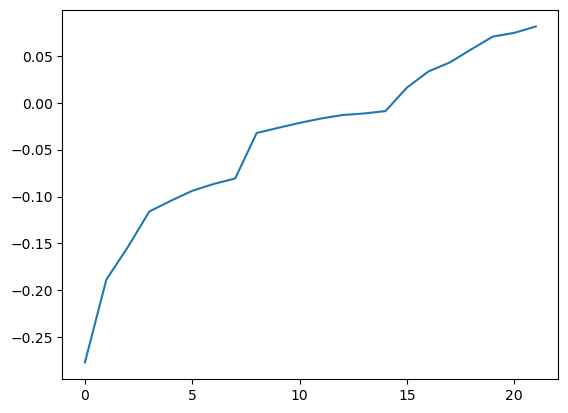

fit df.shape (179957, 39)


INFO:tensorflow:Assets written to: /tmp/tmp5rdmfpgr/assets


INFO:tensorflow:Assets written to: /tmp/tmp5rdmfpgr/assets
2022-11-09 14:04:00.783325: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-09 14:04:00.783430: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-09 14:04:00.783661: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp5rdmfpgr
2022-11-09 14:04:00.785966: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-09 14:04:00.786030: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp5rdmfpgr
2022-11-09 14:04:00.794292: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-09 14:04:00.858600: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp5rdmfpgr
2022-11-09 14:04:00.875006: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp90a2y6jq/assets


INFO:tensorflow:Assets written to: /tmp/tmp90a2y6jq/assets
2022-11-09 14:04:02.753720: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-09 14:04:02.753813: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-09 14:04:02.754031: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp90a2y6jq
2022-11-09 14:04:02.756274: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-09 14:04:02.756323: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp90a2y6jq
2022-11-09 14:04:02.763635: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-09 14:04:02.827635: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp90a2y6jq
2022-11-09 14:04:02.845413: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp559qdfi6/assets


INFO:tensorflow:Assets written to: /tmp/tmp559qdfi6/assets
2022-11-09 14:04:04.756525: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-09 14:04:04.756619: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-09 14:04:04.756837: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp559qdfi6
2022-11-09 14:04:04.759112: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-09 14:04:04.759165: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp559qdfi6
2022-11-09 14:04:04.767149: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-09 14:04:04.830798: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp559qdfi6
2022-11-09 14:04:04.847600: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp2pd7v0i0/assets


INFO:tensorflow:Assets written to: /tmp/tmp2pd7v0i0/assets
2022-11-09 14:04:06.713440: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-09 14:04:06.713534: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-09 14:04:06.713760: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp2pd7v0i0
2022-11-09 14:04:06.715963: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-09 14:04:06.716017: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp2pd7v0i0
2022-11-09 14:04:06.723396: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-09 14:04:06.784530: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp2pd7v0i0
2022-11-09 14:04:06.801664: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpgj0g_999/assets


INFO:tensorflow:Assets written to: /tmp/tmpgj0g_999/assets
2022-11-09 14:04:08.696080: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-09 14:04:08.696171: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-09 14:04:08.696399: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpgj0g_999
2022-11-09 14:04:08.698605: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-09 14:04:08.698651: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpgj0g_999
2022-11-09 14:04:08.706163: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-09 14:04:08.767950: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpgj0g_999
2022-11-09 14:04:08.784310: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp398gmeqd/assets


INFO:tensorflow:Assets written to: /tmp/tmp398gmeqd/assets
2022-11-09 14:04:12.317683: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-09 14:04:12.317780: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-09 14:04:12.318011: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp398gmeqd
2022-11-09 14:04:12.322148: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-09 14:04:12.322222: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp398gmeqd
2022-11-09 14:04:12.335406: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-09 14:04:12.411579: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp398gmeqd
2022-11-09 14:04:12.434052: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp3yawyche/assets


INFO:tensorflow:Assets written to: /tmp/tmp3yawyche/assets
2022-11-09 14:04:14.442918: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-09 14:04:14.443008: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-09 14:04:14.443237: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp3yawyche
2022-11-09 14:04:14.445770: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-09 14:04:14.445824: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp3yawyche
2022-11-09 14:04:14.454711: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-09 14:04:14.520550: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp3yawyche
2022-11-09 14:04:14.537757: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpqvxi4ajw/assets


INFO:tensorflow:Assets written to: /tmp/tmpqvxi4ajw/assets
2022-11-09 14:04:16.521366: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-09 14:04:16.521478: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-09 14:04:16.521705: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpqvxi4ajw
2022-11-09 14:04:16.524127: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-09 14:04:16.524200: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpqvxi4ajw
2022-11-09 14:04:16.532847: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-09 14:04:16.602971: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpqvxi4ajw
2022-11-09 14:04:16.623350: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmputbkh9pm/assets


INFO:tensorflow:Assets written to: /tmp/tmputbkh9pm/assets
2022-11-09 14:04:18.593640: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-09 14:04:18.593741: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-09 14:04:18.593994: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmputbkh9pm
2022-11-09 14:04:18.596462: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-09 14:04:18.596517: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmputbkh9pm
2022-11-09 14:04:18.604066: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-09 14:04:18.666029: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmputbkh9pm
2022-11-09 14:04:18.683468: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpke35ki_k/assets


INFO:tensorflow:Assets written to: /tmp/tmpke35ki_k/assets
2022-11-09 14:04:20.605007: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-09 14:04:20.605101: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-09 14:04:20.605325: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpke35ki_k
2022-11-09 14:04:20.607628: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-09 14:04:20.607687: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpke35ki_k
2022-11-09 14:04:20.615265: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-09 14:04:20.676862: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpke35ki_k
2022-11-09 14:04:20.694913: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

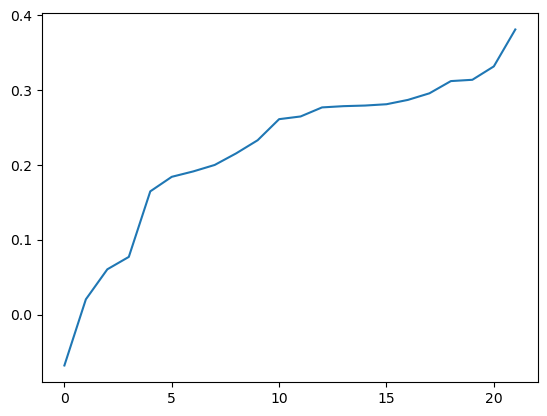

fit df.shape (180191, 39)


INFO:tensorflow:Assets written to: /tmp/tmpto33iln_/assets


INFO:tensorflow:Assets written to: /tmp/tmpto33iln_/assets
2022-11-09 14:16:01.233128: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-09 14:16:01.233227: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-09 14:16:01.233460: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpto33iln_
2022-11-09 14:16:01.235761: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-09 14:16:01.235816: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpto33iln_
2022-11-09 14:16:01.243649: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-09 14:16:01.308159: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpto33iln_
2022-11-09 14:16:01.326302: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmplsbvw6a3/assets


INFO:tensorflow:Assets written to: /tmp/tmplsbvw6a3/assets
2022-11-09 14:16:03.259643: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-09 14:16:03.259744: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-09 14:16:03.259971: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmplsbvw6a3
2022-11-09 14:16:03.262267: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-09 14:16:03.262317: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmplsbvw6a3
2022-11-09 14:16:03.270056: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-09 14:16:03.333257: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmplsbvw6a3
2022-11-09 14:16:03.349744: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpqniu92ke/assets


INFO:tensorflow:Assets written to: /tmp/tmpqniu92ke/assets
2022-11-09 14:16:05.229948: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-09 14:16:05.230051: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-09 14:16:05.230302: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpqniu92ke
2022-11-09 14:16:05.232589: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-09 14:16:05.232649: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpqniu92ke
2022-11-09 14:16:05.240933: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-09 14:16:05.306638: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpqniu92ke
2022-11-09 14:16:05.324839: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpjnp26cf7/assets


INFO:tensorflow:Assets written to: /tmp/tmpjnp26cf7/assets
2022-11-09 14:16:07.230939: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-09 14:16:07.231037: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-09 14:16:07.231261: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpjnp26cf7
2022-11-09 14:16:07.233467: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-09 14:16:07.233514: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpjnp26cf7
2022-11-09 14:16:07.240915: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-09 14:16:07.305868: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpjnp26cf7
2022-11-09 14:16:07.321982: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpajp2bhtg/assets


INFO:tensorflow:Assets written to: /tmp/tmpajp2bhtg/assets
2022-11-09 14:16:09.225617: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-09 14:16:09.225704: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-09 14:16:09.225928: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpajp2bhtg
2022-11-09 14:16:09.228219: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-09 14:16:09.228270: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpajp2bhtg
2022-11-09 14:16:09.235974: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-09 14:16:09.303114: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpajp2bhtg
2022-11-09 14:16:09.321637: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmphndtzcxd/assets


INFO:tensorflow:Assets written to: /tmp/tmphndtzcxd/assets
2022-11-09 14:16:11.185113: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-09 14:16:11.185204: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-09 14:16:11.185432: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmphndtzcxd
2022-11-09 14:16:11.187625: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-09 14:16:11.187671: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmphndtzcxd
2022-11-09 14:16:11.195096: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-09 14:16:11.255072: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmphndtzcxd
2022-11-09 14:16:11.270724: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp5z42j2he/assets


INFO:tensorflow:Assets written to: /tmp/tmp5z42j2he/assets
2022-11-09 14:16:17.166559: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-09 14:16:17.166650: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-09 14:16:17.166898: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp5z42j2he
2022-11-09 14:16:17.176724: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-09 14:16:17.176796: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp5z42j2he
2022-11-09 14:16:17.206048: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-09 14:16:17.371167: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp5z42j2he
2022-11-09 14:16:17.421267: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpsiexmzv_/assets


INFO:tensorflow:Assets written to: /tmp/tmpsiexmzv_/assets
2022-11-09 14:16:21.456292: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-09 14:16:21.456387: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-09 14:16:21.456619: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpsiexmzv_
2022-11-09 14:16:21.461577: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-09 14:16:21.461645: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpsiexmzv_
2022-11-09 14:16:21.480954: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-09 14:16:21.628654: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpsiexmzv_
2022-11-09 14:16:21.669410: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpkhlk4gh0/assets


INFO:tensorflow:Assets written to: /tmp/tmpkhlk4gh0/assets
2022-11-09 14:16:25.522609: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-09 14:16:25.522698: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-09 14:16:25.523291: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpkhlk4gh0
2022-11-09 14:16:25.528548: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-09 14:16:25.528613: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpkhlk4gh0
2022-11-09 14:16:25.542953: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-09 14:16:25.666251: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpkhlk4gh0
2022-11-09 14:16:25.701725: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpac8hvnp6/assets


INFO:tensorflow:Assets written to: /tmp/tmpac8hvnp6/assets
2022-11-09 14:16:29.223578: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-09 14:16:29.223681: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-09 14:16:29.223936: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpac8hvnp6
2022-11-09 14:16:29.228414: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-09 14:16:29.228476: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpac8hvnp6
2022-11-09 14:16:29.241283: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-09 14:16:29.354155: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpac8hvnp6
2022-11-09 14:16:29.384414: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

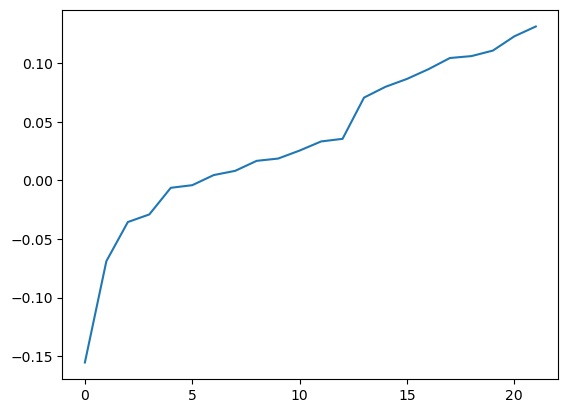

return without cost statistics
mean 0.0026733482441065274
std 0.024778941302512077
sharpe 0.10788791221824738
double sharpe 1.246462989427445
max drawdown 0.5562287150190066
return with cost statistics
mean 0.0014162591768518734
std 0.0247914026788944
sharpe 0.05712702888157166
double sharpe 0.6148702855046565
max drawdown 0.5567520149964373


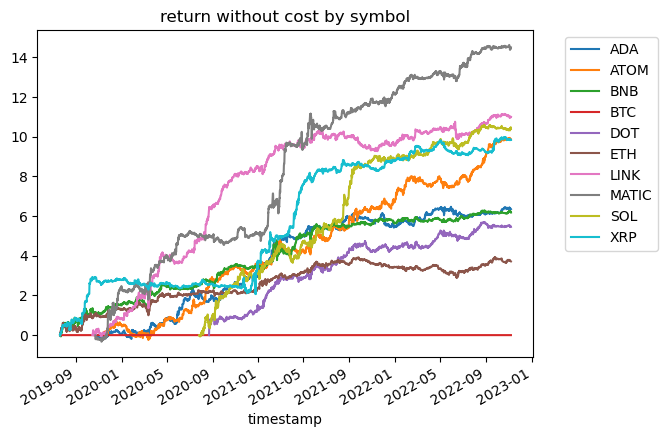

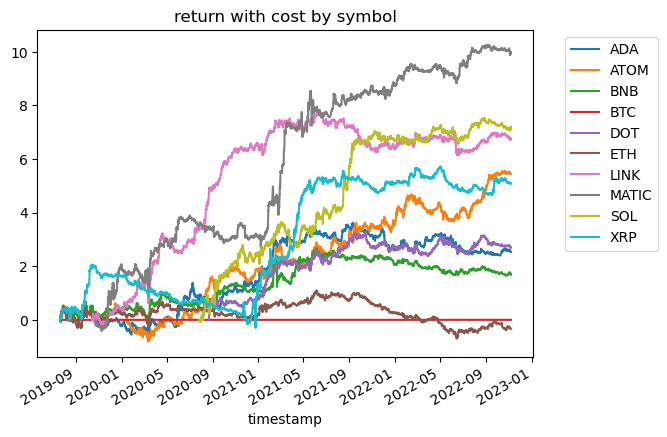

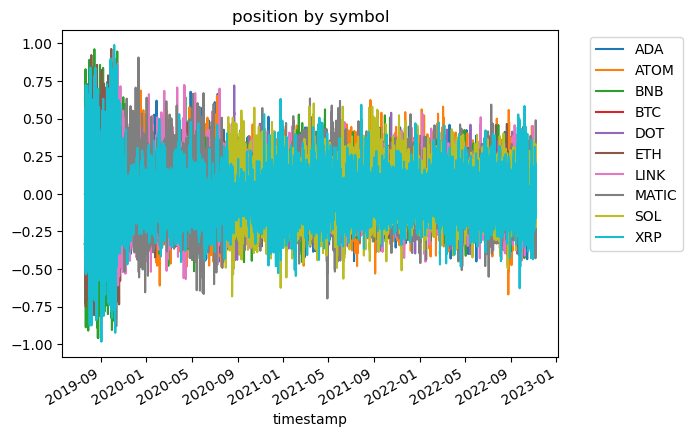

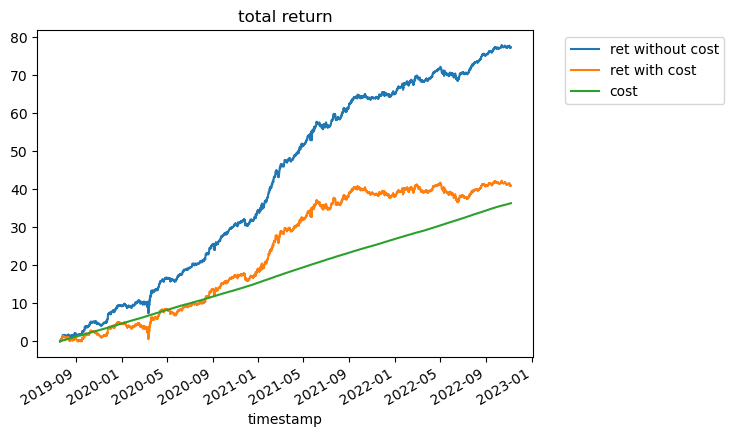

fit df.shape (232490, 39)


INFO:tensorflow:Assets written to: /tmp/tmp190zl8ou/assets


INFO:tensorflow:Assets written to: /tmp/tmp190zl8ou/assets
2022-11-09 15:17:47.347603: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-09 15:17:47.347691: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-09 15:17:47.347923: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp190zl8ou
2022-11-09 15:17:47.350270: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-09 15:17:47.350323: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp190zl8ou
2022-11-09 15:17:47.357981: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-09 15:17:47.423235: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp190zl8ou
2022-11-09 15:17:47.440668: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpzwn4qspf/assets


INFO:tensorflow:Assets written to: /tmp/tmpzwn4qspf/assets
2022-11-09 15:17:49.393306: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-09 15:17:49.393408: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-09 15:17:49.393630: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpzwn4qspf
2022-11-09 15:17:49.395880: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-09 15:17:49.395935: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpzwn4qspf
2022-11-09 15:17:49.403712: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-09 15:17:49.472131: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpzwn4qspf
2022-11-09 15:17:49.490969: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp9yopuq2c/assets


INFO:tensorflow:Assets written to: /tmp/tmp9yopuq2c/assets
2022-11-09 15:17:51.444799: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-09 15:17:51.444906: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-09 15:17:51.445168: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp9yopuq2c
2022-11-09 15:17:51.447479: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-09 15:17:51.447539: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp9yopuq2c
2022-11-09 15:17:51.455512: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-09 15:17:51.524907: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp9yopuq2c
2022-11-09 15:17:51.542137: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp7d9o61wi/assets


INFO:tensorflow:Assets written to: /tmp/tmp7d9o61wi/assets
2022-11-09 15:17:53.518210: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-09 15:17:53.518300: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-09 15:17:53.518525: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp7d9o61wi
2022-11-09 15:17:53.520728: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-09 15:17:53.520770: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp7d9o61wi
2022-11-09 15:17:53.528626: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-09 15:17:53.591434: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp7d9o61wi
2022-11-09 15:17:53.608192: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpzvwutpki/assets


INFO:tensorflow:Assets written to: /tmp/tmpzvwutpki/assets
2022-11-09 15:17:55.541173: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-09 15:17:55.541274: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-09 15:17:55.541500: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpzvwutpki
2022-11-09 15:17:55.543750: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-09 15:17:55.543808: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpzvwutpki
2022-11-09 15:17:55.551786: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-09 15:17:55.619402: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpzvwutpki
2022-11-09 15:17:55.640174: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpxgz6actn/assets


INFO:tensorflow:Assets written to: /tmp/tmpxgz6actn/assets
2022-11-09 15:17:57.674026: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-09 15:17:57.674167: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-09 15:17:57.674404: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpxgz6actn
2022-11-09 15:17:57.676723: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-09 15:17:57.676779: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpxgz6actn
2022-11-09 15:17:57.684939: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-09 15:17:57.749073: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpxgz6actn
2022-11-09 15:17:57.767331: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp2uk86hcd/assets


INFO:tensorflow:Assets written to: /tmp/tmp2uk86hcd/assets
2022-11-09 15:17:59.688100: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-09 15:17:59.688208: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-09 15:17:59.688432: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp2uk86hcd
2022-11-09 15:17:59.690716: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-09 15:17:59.690771: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp2uk86hcd
2022-11-09 15:17:59.698682: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-09 15:17:59.765456: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp2uk86hcd
2022-11-09 15:17:59.783390: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpb21j43wa/assets


INFO:tensorflow:Assets written to: /tmp/tmpb21j43wa/assets
2022-11-09 15:18:01.731144: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-09 15:18:01.731252: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-09 15:18:01.731491: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpb21j43wa
2022-11-09 15:18:01.733770: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-09 15:18:01.733833: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpb21j43wa
2022-11-09 15:18:01.741675: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-09 15:18:01.810652: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpb21j43wa
2022-11-09 15:18:01.830304: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpbyar3u8g/assets


INFO:tensorflow:Assets written to: /tmp/tmpbyar3u8g/assets
2022-11-09 15:18:03.835642: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-09 15:18:03.835728: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-09 15:18:03.835945: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpbyar3u8g
2022-11-09 15:18:03.838167: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-09 15:18:03.838221: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpbyar3u8g
2022-11-09 15:18:03.845555: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-09 15:18:03.906707: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpbyar3u8g
2022-11-09 15:18:03.923115: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmprto8alka/assets


INFO:tensorflow:Assets written to: /tmp/tmprto8alka/assets
2022-11-09 15:18:05.855237: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-09 15:18:05.855329: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-09 15:18:05.855553: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmprto8alka
2022-11-09 15:18:05.858012: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-09 15:18:05.858104: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmprto8alka
2022-11-09 15:18:05.869853: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-09 15:18:05.935204: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmprto8alka
2022-11-09 15:18:05.953696: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpk6jhvx58/assets


INFO:tensorflow:Assets written to: /tmp/tmpk6jhvx58/assets
2022-11-09 15:18:07.873002: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-09 15:18:07.873099: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-09 15:18:07.873322: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpk6jhvx58
2022-11-09 15:18:07.875803: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-09 15:18:07.875849: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpk6jhvx58
2022-11-09 15:18:07.887185: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-09 15:18:07.951929: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpk6jhvx58
2022-11-09 15:18:07.968505: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpp942l24r/assets


INFO:tensorflow:Assets written to: /tmp/tmpp942l24r/assets
2022-11-09 15:18:09.918777: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-09 15:18:09.918873: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-09 15:18:09.919095: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpp942l24r
2022-11-09 15:18:09.921591: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-09 15:18:09.921646: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpp942l24r
2022-11-09 15:18:09.932765: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-09 15:18:09.996746: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpp942l24r
2022-11-09 15:18:10.013702: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp7xt_1phq/assets


INFO:tensorflow:Assets written to: /tmp/tmp7xt_1phq/assets
2022-11-09 15:18:15.189541: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-09 15:18:15.189643: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-09 15:18:15.189883: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp7xt_1phq
2022-11-09 15:18:15.195418: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-09 15:18:15.195492: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp7xt_1phq
2022-11-09 15:18:15.214542: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-09 15:18:15.307076: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp7xt_1phq
2022-11-09 15:18:15.335574: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpx10ctvv9/assets


INFO:tensorflow:Assets written to: /tmp/tmpx10ctvv9/assets
2022-11-09 15:18:17.444755: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-09 15:18:17.444857: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-09 15:18:17.445080: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpx10ctvv9
2022-11-09 15:18:17.448077: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-09 15:18:17.448138: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpx10ctvv9
2022-11-09 15:18:17.457776: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-09 15:18:17.531231: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpx10ctvv9
2022-11-09 15:18:17.552822: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp56_dvq10/assets


INFO:tensorflow:Assets written to: /tmp/tmp56_dvq10/assets
2022-11-09 15:18:19.589374: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-09 15:18:19.589472: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-09 15:18:19.589698: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp56_dvq10
2022-11-09 15:18:19.592159: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-09 15:18:19.592214: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp56_dvq10
2022-11-09 15:18:19.600629: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-09 15:18:19.670276: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp56_dvq10
2022-11-09 15:18:19.689230: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpxzd53vez/assets


INFO:tensorflow:Assets written to: /tmp/tmpxzd53vez/assets
2022-11-09 15:18:21.630808: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-09 15:18:21.630905: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-09 15:18:21.631144: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpxzd53vez
2022-11-09 15:18:21.633525: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-09 15:18:21.633583: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpxzd53vez
2022-11-09 15:18:21.641855: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-09 15:18:21.716524: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpxzd53vez
2022-11-09 15:18:21.735479: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpuu6f9s45/assets


INFO:tensorflow:Assets written to: /tmp/tmpuu6f9s45/assets
2022-11-09 15:18:23.706829: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-09 15:18:23.706920: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-09 15:18:23.707147: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpuu6f9s45
2022-11-09 15:18:23.709500: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-09 15:18:23.709579: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpuu6f9s45
2022-11-09 15:18:23.718137: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-09 15:18:23.784412: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpuu6f9s45
2022-11-09 15:18:23.805081: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpuvxikf73/assets


INFO:tensorflow:Assets written to: /tmp/tmpuvxikf73/assets
2022-11-09 15:18:25.761526: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-09 15:18:25.761626: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-09 15:18:25.761854: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpuvxikf73
2022-11-09 15:18:25.764102: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-09 15:18:25.764152: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpuvxikf73
2022-11-09 15:18:25.772003: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-09 15:18:25.838746: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpuvxikf73
2022-11-09 15:18:25.857431: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpyj6bz3si/assets


INFO:tensorflow:Assets written to: /tmp/tmpyj6bz3si/assets
2022-11-09 15:18:27.775431: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-09 15:18:27.775530: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-09 15:18:27.775765: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpyj6bz3si
2022-11-09 15:18:27.778030: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-09 15:18:27.778130: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpyj6bz3si
2022-11-09 15:18:27.785884: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-09 15:18:27.849671: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpyj6bz3si
2022-11-09 15:18:27.867260: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp1gbxslul/assets


INFO:tensorflow:Assets written to: /tmp/tmp1gbxslul/assets
2022-11-09 15:18:29.816176: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-09 15:18:29.816286: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-09 15:18:29.816513: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp1gbxslul
2022-11-09 15:18:29.818842: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-09 15:18:29.818911: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp1gbxslul
2022-11-09 15:18:29.826988: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-09 15:18:29.893483: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp1gbxslul
2022-11-09 15:18:29.911641: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpp3amgxmr/assets


INFO:tensorflow:Assets written to: /tmp/tmpp3amgxmr/assets
2022-11-09 15:18:31.893729: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-09 15:18:31.893830: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-09 15:18:31.894053: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpp3amgxmr
2022-11-09 15:18:31.896323: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-09 15:18:31.896388: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpp3amgxmr
2022-11-09 15:18:31.904317: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-09 15:18:31.970247: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpp3amgxmr
2022-11-09 15:18:31.990963: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmppbibx5nt/assets


INFO:tensorflow:Assets written to: /tmp/tmppbibx5nt/assets
2022-11-09 15:18:34.023221: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-09 15:18:34.023319: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-09 15:18:34.023544: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmppbibx5nt
2022-11-09 15:18:34.025759: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-09 15:18:34.025812: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmppbibx5nt
2022-11-09 15:18:34.033162: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-09 15:18:34.096793: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmppbibx5nt
2022-11-09 15:18:34.113921: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmps1rl0cvu/assets


INFO:tensorflow:Assets written to: /tmp/tmps1rl0cvu/assets
2022-11-09 15:18:36.111332: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-09 15:18:36.111435: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-09 15:18:36.111664: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmps1rl0cvu
2022-11-09 15:18:36.113910: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-09 15:18:36.113970: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmps1rl0cvu
2022-11-09 15:18:36.121724: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-09 15:18:36.189276: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmps1rl0cvu
2022-11-09 15:18:36.207751: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmps2l5dgib/assets


INFO:tensorflow:Assets written to: /tmp/tmps2l5dgib/assets
2022-11-09 15:18:38.201865: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-09 15:18:38.201993: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-09 15:18:38.202256: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmps2l5dgib
2022-11-09 15:18:38.204551: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-09 15:18:38.204612: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmps2l5dgib
2022-11-09 15:18:38.212247: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-09 15:18:38.276092: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmps2l5dgib
2022-11-09 15:18:38.295387: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpeg38y1vq/assets


INFO:tensorflow:Assets written to: /tmp/tmpeg38y1vq/assets
2022-11-09 15:18:40.173348: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-09 15:18:40.173447: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-09 15:18:40.173683: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpeg38y1vq
2022-11-09 15:18:40.175947: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-09 15:18:40.175997: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpeg38y1vq
2022-11-09 15:18:40.183407: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-09 15:18:40.246674: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpeg38y1vq
2022-11-09 15:18:40.263744: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpo6p0p84f/assets


INFO:tensorflow:Assets written to: /tmp/tmpo6p0p84f/assets
2022-11-09 15:18:42.202663: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-09 15:18:42.202763: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-09 15:18:42.203182: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpo6p0p84f
2022-11-09 15:18:42.205490: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-09 15:18:42.205549: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpo6p0p84f
2022-11-09 15:18:42.213755: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-09 15:18:42.283162: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpo6p0p84f
2022-11-09 15:18:42.300323: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmphpkkpkcg/assets


INFO:tensorflow:Assets written to: /tmp/tmphpkkpkcg/assets
2022-11-09 15:18:47.606833: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-09 15:18:47.606933: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-09 15:18:47.607181: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmphpkkpkcg
2022-11-09 15:18:47.612686: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-09 15:18:47.612755: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmphpkkpkcg
2022-11-09 15:18:47.633758: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-09 15:18:47.740169: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmphpkkpkcg
2022-11-09 15:18:47.774752: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpqhzqbhrm/assets


INFO:tensorflow:Assets written to: /tmp/tmpqhzqbhrm/assets
2022-11-09 15:18:49.973581: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-09 15:18:49.973668: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-09 15:18:49.973900: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpqhzqbhrm
2022-11-09 15:18:49.977371: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-09 15:18:49.977450: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpqhzqbhrm
2022-11-09 15:18:49.989459: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-09 15:18:50.071389: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpqhzqbhrm
2022-11-09 15:18:50.094789: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpsaqgsaoq/assets


INFO:tensorflow:Assets written to: /tmp/tmpsaqgsaoq/assets
2022-11-09 15:18:52.182058: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-09 15:18:52.182181: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-09 15:18:52.182428: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpsaqgsaoq
2022-11-09 15:18:52.185149: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-09 15:18:52.185213: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpsaqgsaoq
2022-11-09 15:18:52.195196: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-09 15:18:52.273577: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpsaqgsaoq
2022-11-09 15:18:52.296792: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp36mdzg1l/assets


INFO:tensorflow:Assets written to: /tmp/tmp36mdzg1l/assets
2022-11-09 15:18:54.243284: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-09 15:18:54.243382: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-09 15:18:54.243620: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp36mdzg1l
2022-11-09 15:18:54.246012: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-09 15:18:54.246106: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp36mdzg1l
2022-11-09 15:18:54.254541: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-09 15:18:54.322839: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp36mdzg1l
2022-11-09 15:18:54.343022: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpvsbkcr6c/assets


INFO:tensorflow:Assets written to: /tmp/tmpvsbkcr6c/assets
2022-11-09 15:18:56.269484: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-09 15:18:56.269584: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-09 15:18:56.269850: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpvsbkcr6c
2022-11-09 15:18:56.272221: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-09 15:18:56.272282: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpvsbkcr6c
2022-11-09 15:18:56.280753: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-09 15:18:56.352126: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpvsbkcr6c
2022-11-09 15:18:56.373779: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpx1lqn878/assets


INFO:tensorflow:Assets written to: /tmp/tmpx1lqn878/assets
2022-11-09 15:18:58.314590: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-09 15:18:58.314684: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-09 15:18:58.314906: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpx1lqn878
2022-11-09 15:18:58.317168: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-09 15:18:58.317217: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpx1lqn878
2022-11-09 15:18:58.325377: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-09 15:18:58.393949: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpx1lqn878
2022-11-09 15:18:58.412993: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpnjs0xsac/assets


INFO:tensorflow:Assets written to: /tmp/tmpnjs0xsac/assets
2022-11-09 15:19:00.354197: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-09 15:19:00.354294: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-09 15:19:00.354516: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpnjs0xsac
2022-11-09 15:19:00.356782: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-09 15:19:00.356840: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpnjs0xsac
2022-11-09 15:19:00.365071: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-09 15:19:00.434191: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpnjs0xsac
2022-11-09 15:19:00.451837: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpgwg3jdra/assets


INFO:tensorflow:Assets written to: /tmp/tmpgwg3jdra/assets
2022-11-09 15:19:02.407380: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-09 15:19:02.407477: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-09 15:19:02.407710: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpgwg3jdra
2022-11-09 15:19:02.410025: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-09 15:19:02.410134: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpgwg3jdra
2022-11-09 15:19:02.418152: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-09 15:19:02.487282: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpgwg3jdra
2022-11-09 15:19:02.506133: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpy0uncq1d/assets


INFO:tensorflow:Assets written to: /tmp/tmpy0uncq1d/assets
2022-11-09 15:19:04.389709: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-09 15:19:04.389812: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-09 15:19:04.390037: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpy0uncq1d
2022-11-09 15:19:04.392300: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-09 15:19:04.392360: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpy0uncq1d
2022-11-09 15:19:04.400277: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-09 15:19:04.468897: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpy0uncq1d
2022-11-09 15:19:04.487310: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmppky3qhoo/assets


INFO:tensorflow:Assets written to: /tmp/tmppky3qhoo/assets
2022-11-09 15:19:06.443051: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-09 15:19:06.443161: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-09 15:19:06.443384: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmppky3qhoo
2022-11-09 15:19:06.445638: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-09 15:19:06.445706: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmppky3qhoo
2022-11-09 15:19:06.453604: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-09 15:19:06.520753: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmppky3qhoo
2022-11-09 15:19:06.538690: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp0x4audua/assets


INFO:tensorflow:Assets written to: /tmp/tmp0x4audua/assets
2022-11-09 15:19:10.919927: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-09 15:19:10.920031: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-09 15:19:10.920294: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp0x4audua
2022-11-09 15:19:10.927581: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-09 15:19:10.927655: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp0x4audua
2022-11-09 15:19:10.965999: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-09 15:19:11.171515: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp0x4audua
2022-11-09 15:19:11.231237: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp8ut15ugt/assets


INFO:tensorflow:Assets written to: /tmp/tmp8ut15ugt/assets
2022-11-09 15:19:13.821518: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-09 15:19:13.821611: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-09 15:19:13.821843: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp8ut15ugt
2022-11-09 15:19:13.827280: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-09 15:19:13.827347: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp8ut15ugt
2022-11-09 15:19:13.847034: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-09 15:19:13.941636: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp8ut15ugt
2022-11-09 15:19:13.971369: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpocouuijf/assets


INFO:tensorflow:Assets written to: /tmp/tmpocouuijf/assets
2022-11-09 15:19:16.126968: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-09 15:19:16.127064: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-09 15:19:16.127287: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpocouuijf
2022-11-09 15:19:16.130581: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-09 15:19:16.130629: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpocouuijf
2022-11-09 15:19:16.141277: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-09 15:19:16.209913: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpocouuijf
2022-11-09 15:19:16.229465: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp481bh5ve/assets


INFO:tensorflow:Assets written to: /tmp/tmp481bh5ve/assets
2022-11-09 15:19:18.254199: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-09 15:19:18.254301: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-09 15:19:18.254541: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp481bh5ve
2022-11-09 15:19:18.257314: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-09 15:19:18.257385: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp481bh5ve
2022-11-09 15:19:18.268055: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-09 15:19:18.347999: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp481bh5ve
2022-11-09 15:19:18.370588: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpi7ew34pp/assets


INFO:tensorflow:Assets written to: /tmp/tmpi7ew34pp/assets
2022-11-09 15:19:20.385544: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-09 15:19:20.385639: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-09 15:19:20.385861: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpi7ew34pp
2022-11-09 15:19:20.388377: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-09 15:19:20.388438: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpi7ew34pp
2022-11-09 15:19:20.396755: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-09 15:19:20.461814: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpi7ew34pp
2022-11-09 15:19:20.479412: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpb96vr6vc/assets


INFO:tensorflow:Assets written to: /tmp/tmpb96vr6vc/assets
2022-11-09 15:19:22.445058: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-09 15:19:22.445155: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-09 15:19:22.445376: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpb96vr6vc
2022-11-09 15:19:22.447867: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-09 15:19:22.447923: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpb96vr6vc
2022-11-09 15:19:22.456141: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-09 15:19:22.524799: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpb96vr6vc
2022-11-09 15:19:22.542661: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp7_b0ig7x/assets


INFO:tensorflow:Assets written to: /tmp/tmp7_b0ig7x/assets
2022-11-09 15:19:24.575276: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-09 15:19:24.575382: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-09 15:19:24.575616: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp7_b0ig7x
2022-11-09 15:19:24.578007: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-09 15:19:24.578114: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp7_b0ig7x
2022-11-09 15:19:24.586839: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-09 15:19:24.660152: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp7_b0ig7x
2022-11-09 15:19:24.681048: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpyzi7t7gg/assets


INFO:tensorflow:Assets written to: /tmp/tmpyzi7t7gg/assets
2022-11-09 15:19:26.682262: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-09 15:19:26.682362: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-09 15:19:26.682586: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpyzi7t7gg
2022-11-09 15:19:26.684934: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-09 15:19:26.685001: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpyzi7t7gg
2022-11-09 15:19:26.693331: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-09 15:19:26.762351: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpyzi7t7gg
2022-11-09 15:19:26.783469: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpxm1mqdx1/assets


INFO:tensorflow:Assets written to: /tmp/tmpxm1mqdx1/assets
2022-11-09 15:19:28.735221: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-09 15:19:28.735328: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-09 15:19:28.735582: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpxm1mqdx1
2022-11-09 15:19:28.737928: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-09 15:19:28.737997: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpxm1mqdx1
2022-11-09 15:19:28.745952: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-09 15:19:28.812758: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpxm1mqdx1
2022-11-09 15:19:28.829866: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpr1b_c1yt/assets


INFO:tensorflow:Assets written to: /tmp/tmpr1b_c1yt/assets
2022-11-09 15:19:30.754511: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-09 15:19:30.754620: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-09 15:19:30.754854: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpr1b_c1yt
2022-11-09 15:19:30.757244: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-09 15:19:30.757311: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpr1b_c1yt
2022-11-09 15:19:30.765704: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-09 15:19:30.835404: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpr1b_c1yt
2022-11-09 15:19:30.851705: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpeuzpimw6/assets


INFO:tensorflow:Assets written to: /tmp/tmpeuzpimw6/assets
2022-11-09 15:19:35.407612: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-09 15:19:35.407710: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-09 15:19:35.407949: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpeuzpimw6
2022-11-09 15:19:35.413857: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-09 15:19:35.413928: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpeuzpimw6
2022-11-09 15:19:35.436956: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-09 15:19:35.559763: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpeuzpimw6
2022-11-09 15:19:35.599632: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp7ydflqd0/assets


INFO:tensorflow:Assets written to: /tmp/tmp7ydflqd0/assets
2022-11-09 15:19:37.961828: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-09 15:19:37.961935: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-09 15:19:37.962191: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp7ydflqd0
2022-11-09 15:19:37.966374: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-09 15:19:37.966444: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp7ydflqd0
2022-11-09 15:19:37.980516: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-09 15:19:38.057786: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp7ydflqd0
2022-11-09 15:19:38.080602: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpe_fhvod8/assets


INFO:tensorflow:Assets written to: /tmp/tmpe_fhvod8/assets
2022-11-09 15:19:40.148900: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-09 15:19:40.149031: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-09 15:19:40.149273: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpe_fhvod8
2022-11-09 15:19:40.152199: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-09 15:19:40.152268: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpe_fhvod8
2022-11-09 15:19:40.162744: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-09 15:19:40.242303: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpe_fhvod8
2022-11-09 15:19:40.268641: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmppvu7j080/assets


INFO:tensorflow:Assets written to: /tmp/tmppvu7j080/assets
2022-11-09 15:19:42.314293: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-09 15:19:42.314398: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-09 15:19:42.314618: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmppvu7j080
2022-11-09 15:19:42.317233: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-09 15:19:42.317298: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmppvu7j080
2022-11-09 15:19:42.326543: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-09 15:19:42.399697: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmppvu7j080
2022-11-09 15:19:42.419908: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmph5l4_ymz/assets


INFO:tensorflow:Assets written to: /tmp/tmph5l4_ymz/assets
2022-11-09 15:19:44.383038: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-09 15:19:44.383151: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-09 15:19:44.383375: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmph5l4_ymz
2022-11-09 15:19:44.385949: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-09 15:19:44.386036: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmph5l4_ymz
2022-11-09 15:19:44.395147: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-09 15:19:44.467913: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmph5l4_ymz
2022-11-09 15:19:44.489152: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpjo9t6r1h/assets


INFO:tensorflow:Assets written to: /tmp/tmpjo9t6r1h/assets
2022-11-09 15:19:46.463565: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-09 15:19:46.463662: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-09 15:19:46.463887: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpjo9t6r1h
2022-11-09 15:19:46.466348: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-09 15:19:46.466413: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpjo9t6r1h
2022-11-09 15:19:46.475302: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-09 15:19:46.545268: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpjo9t6r1h
2022-11-09 15:19:46.563672: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp6yuw3abf/assets


INFO:tensorflow:Assets written to: /tmp/tmp6yuw3abf/assets
2022-11-09 15:19:48.521564: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-09 15:19:48.521658: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-09 15:19:48.521876: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp6yuw3abf
2022-11-09 15:19:48.524191: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-09 15:19:48.524237: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp6yuw3abf
2022-11-09 15:19:48.531886: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-09 15:19:48.599305: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp6yuw3abf
2022-11-09 15:19:48.617961: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmps3wealy_/assets


INFO:tensorflow:Assets written to: /tmp/tmps3wealy_/assets
2022-11-09 15:19:50.579332: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-09 15:19:50.579435: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-09 15:19:50.579658: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmps3wealy_
2022-11-09 15:19:50.582037: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-09 15:19:50.582151: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmps3wealy_
2022-11-09 15:19:50.590749: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-09 15:19:50.663457: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmps3wealy_
2022-11-09 15:19:50.683795: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpkd1oifo3/assets


INFO:tensorflow:Assets written to: /tmp/tmpkd1oifo3/assets
2022-11-09 15:19:54.995622: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-09 15:19:54.995723: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-09 15:19:54.995968: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpkd1oifo3
2022-11-09 15:19:55.002516: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-09 15:19:55.002594: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpkd1oifo3
2022-11-09 15:19:55.030420: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-09 15:19:55.177452: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpkd1oifo3
2022-11-09 15:19:55.226572: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp2rdq17dl/assets


INFO:tensorflow:Assets written to: /tmp/tmp2rdq17dl/assets
2022-11-09 15:19:57.562920: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-09 15:19:57.563017: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-09 15:19:57.563261: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp2rdq17dl
2022-11-09 15:19:57.567765: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-09 15:19:57.567825: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp2rdq17dl
2022-11-09 15:19:57.583097: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-09 15:19:57.661695: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp2rdq17dl
2022-11-09 15:19:57.686633: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpf1vw0jmd/assets


INFO:tensorflow:Assets written to: /tmp/tmpf1vw0jmd/assets
2022-11-09 15:19:59.814610: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-09 15:19:59.814712: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-09 15:19:59.814944: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpf1vw0jmd
2022-11-09 15:19:59.818293: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-09 15:19:59.818372: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpf1vw0jmd
2022-11-09 15:19:59.829366: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-09 15:19:59.909844: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpf1vw0jmd
2022-11-09 15:19:59.932109: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp4cx648az/assets


INFO:tensorflow:Assets written to: /tmp/tmp4cx648az/assets
2022-11-09 15:20:01.964419: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-09 15:20:01.964521: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-09 15:20:01.964745: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp4cx648az
2022-11-09 15:20:01.967545: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-09 15:20:01.967618: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp4cx648az
2022-11-09 15:20:01.977604: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-09 15:20:02.056068: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp4cx648az
2022-11-09 15:20:02.078544: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmphntnswl2/assets


INFO:tensorflow:Assets written to: /tmp/tmphntnswl2/assets
2022-11-09 15:20:04.034666: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-09 15:20:04.034760: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-09 15:20:04.034978: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmphntnswl2
2022-11-09 15:20:04.037521: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-09 15:20:04.037577: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmphntnswl2
2022-11-09 15:20:04.045965: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-09 15:20:04.112445: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmphntnswl2
2022-11-09 15:20:04.129939: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmplv90lueq/assets


INFO:tensorflow:Assets written to: /tmp/tmplv90lueq/assets
2022-11-09 15:20:06.039329: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-09 15:20:06.039446: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-09 15:20:06.039695: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmplv90lueq
2022-11-09 15:20:06.042385: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-09 15:20:06.042465: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmplv90lueq
2022-11-09 15:20:06.051632: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-09 15:20:06.125340: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmplv90lueq
2022-11-09 15:20:06.146721: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpxin47zdj/assets


INFO:tensorflow:Assets written to: /tmp/tmpxin47zdj/assets
2022-11-09 15:20:08.071843: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-09 15:20:08.071936: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-09 15:20:08.072212: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpxin47zdj
2022-11-09 15:20:08.074603: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-09 15:20:08.074660: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpxin47zdj
2022-11-09 15:20:08.082519: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-09 15:20:08.146655: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpxin47zdj
2022-11-09 15:20:08.163430: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpkrpu6fsq/assets


INFO:tensorflow:Assets written to: /tmp/tmpkrpu6fsq/assets
2022-11-09 15:20:11.934289: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-09 15:20:11.934392: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-09 15:20:11.934642: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpkrpu6fsq
2022-11-09 15:20:11.941724: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-09 15:20:11.941795: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpkrpu6fsq
2022-11-09 15:20:11.978961: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-09 15:20:12.195401: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpkrpu6fsq
2022-11-09 15:20:12.262509: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpvazuxdr9/assets


INFO:tensorflow:Assets written to: /tmp/tmpvazuxdr9/assets
2022-11-09 15:20:14.814764: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-09 15:20:14.814855: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-09 15:20:14.815099: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpvazuxdr9
2022-11-09 15:20:14.820335: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-09 15:20:14.820397: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpvazuxdr9
2022-11-09 15:20:14.840324: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-09 15:20:14.947360: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpvazuxdr9
2022-11-09 15:20:14.981920: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpmz0s9x2a/assets


INFO:tensorflow:Assets written to: /tmp/tmpmz0s9x2a/assets
2022-11-09 15:20:17.212457: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-09 15:20:17.212565: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-09 15:20:17.212800: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpmz0s9x2a
2022-11-09 15:20:17.217036: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-09 15:20:17.217219: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpmz0s9x2a
2022-11-09 15:20:17.232062: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-09 15:20:17.309274: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpmz0s9x2a
2022-11-09 15:20:17.332776: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp1r912se_/assets


INFO:tensorflow:Assets written to: /tmp/tmp1r912se_/assets
2022-11-09 15:20:19.353315: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-09 15:20:19.353415: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-09 15:20:19.353636: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp1r912se_
2022-11-09 15:20:19.356389: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-09 15:20:19.356440: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp1r912se_
2022-11-09 15:20:19.365778: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-09 15:20:19.436394: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp1r912se_
2022-11-09 15:20:19.456000: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpfuu2l9tc/assets


INFO:tensorflow:Assets written to: /tmp/tmpfuu2l9tc/assets
2022-11-09 15:20:21.454160: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-09 15:20:21.454255: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-09 15:20:21.454481: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpfuu2l9tc
2022-11-09 15:20:21.457059: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-09 15:20:21.457122: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpfuu2l9tc
2022-11-09 15:20:21.466247: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-09 15:20:21.538779: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpfuu2l9tc
2022-11-09 15:20:21.558729: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpdxjaq41i/assets


INFO:tensorflow:Assets written to: /tmp/tmpdxjaq41i/assets
2022-11-09 15:20:23.500253: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-09 15:20:23.500349: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-09 15:20:23.500578: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpdxjaq41i
2022-11-09 15:20:23.503103: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-09 15:20:23.503170: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpdxjaq41i
2022-11-09 15:20:23.512125: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-09 15:20:23.586463: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpdxjaq41i
2022-11-09 15:20:23.607011: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp8clj_nsg/assets


INFO:tensorflow:Assets written to: /tmp/tmp8clj_nsg/assets
2022-11-09 15:20:25.587951: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-09 15:20:25.588045: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-09 15:20:25.588286: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp8clj_nsg
2022-11-09 15:20:25.590669: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-09 15:20:25.590724: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp8clj_nsg
2022-11-09 15:20:25.599116: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-09 15:20:25.669433: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp8clj_nsg
2022-11-09 15:20:25.688395: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpe97qygsr/assets


INFO:tensorflow:Assets written to: /tmp/tmpe97qygsr/assets
2022-11-09 15:20:29.835822: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-09 15:20:29.835926: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-09 15:20:29.836169: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpe97qygsr
2022-11-09 15:20:29.842390: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-09 15:20:29.842466: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpe97qygsr
2022-11-09 15:20:29.869195: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-09 15:20:30.006185: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpe97qygsr
2022-11-09 15:20:30.048885: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp_orjxccr/assets


INFO:tensorflow:Assets written to: /tmp/tmp_orjxccr/assets
2022-11-09 15:20:32.505176: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-09 15:20:32.505290: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-09 15:20:32.505537: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp_orjxccr
2022-11-09 15:20:32.510799: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-09 15:20:32.510887: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp_orjxccr
2022-11-09 15:20:32.529213: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-09 15:20:32.624783: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp_orjxccr
2022-11-09 15:20:32.655280: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpxmmsn6d9/assets


INFO:tensorflow:Assets written to: /tmp/tmpxmmsn6d9/assets
2022-11-09 15:20:34.691684: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-09 15:20:34.691776: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-09 15:20:34.691993: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpxmmsn6d9
2022-11-09 15:20:34.695011: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-09 15:20:34.695078: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpxmmsn6d9
2022-11-09 15:20:34.705218: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-09 15:20:34.779186: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpxmmsn6d9
2022-11-09 15:20:34.803223: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp5zoe8zmt/assets


INFO:tensorflow:Assets written to: /tmp/tmp5zoe8zmt/assets
2022-11-09 15:20:36.818797: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-09 15:20:36.818890: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-09 15:20:36.819111: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp5zoe8zmt
2022-11-09 15:20:36.821688: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-09 15:20:36.821747: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp5zoe8zmt
2022-11-09 15:20:36.831037: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-09 15:20:36.899359: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp5zoe8zmt
2022-11-09 15:20:36.918617: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp2csg5l37/assets


INFO:tensorflow:Assets written to: /tmp/tmp2csg5l37/assets
2022-11-09 15:20:38.934103: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-09 15:20:38.934208: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-09 15:20:38.934434: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp2csg5l37
2022-11-09 15:20:38.937026: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-09 15:20:38.937087: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp2csg5l37
2022-11-09 15:20:38.945576: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-09 15:20:39.015755: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp2csg5l37
2022-11-09 15:20:39.035532: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpnhqg12p3/assets


INFO:tensorflow:Assets written to: /tmp/tmpnhqg12p3/assets
2022-11-09 15:20:42.886761: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-09 15:20:42.886859: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-09 15:20:42.887098: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpnhqg12p3
2022-11-09 15:20:42.893382: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-09 15:20:42.893455: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpnhqg12p3
2022-11-09 15:20:42.918878: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-09 15:20:43.048092: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpnhqg12p3
2022-11-09 15:20:43.087278: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpq6ueb_nm/assets


INFO:tensorflow:Assets written to: /tmp/tmpq6ueb_nm/assets
2022-11-09 15:20:45.413674: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-09 15:20:45.413778: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-09 15:20:45.414017: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpq6ueb_nm
2022-11-09 15:20:45.419086: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-09 15:20:45.419153: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpq6ueb_nm
2022-11-09 15:20:45.434467: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-09 15:20:45.524356: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpq6ueb_nm
2022-11-09 15:20:45.548445: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp7g0g7g0f/assets


INFO:tensorflow:Assets written to: /tmp/tmp7g0g7g0f/assets
2022-11-09 15:20:47.697144: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-09 15:20:47.697246: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-09 15:20:47.697471: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp7g0g7g0f
2022-11-09 15:20:47.700738: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-09 15:20:47.700811: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp7g0g7g0f
2022-11-09 15:20:47.712310: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-09 15:20:47.789389: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp7g0g7g0f
2022-11-09 15:20:47.811091: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp7h56lpie/assets


INFO:tensorflow:Assets written to: /tmp/tmp7h56lpie/assets
2022-11-09 15:20:49.840654: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-09 15:20:49.840753: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-09 15:20:49.840981: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp7h56lpie
2022-11-09 15:20:49.843662: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-09 15:20:49.843721: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp7h56lpie
2022-11-09 15:20:49.853007: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-09 15:20:49.924989: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp7h56lpie
2022-11-09 15:20:49.944629: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpinch00bi/assets


INFO:tensorflow:Assets written to: /tmp/tmpinch00bi/assets
2022-11-09 15:20:53.332808: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-09 15:20:53.332895: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-09 15:20:53.333142: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpinch00bi
2022-11-09 15:20:53.339073: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-09 15:20:53.339144: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpinch00bi
2022-11-09 15:20:53.364858: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-09 15:20:53.491388: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpinch00bi
2022-11-09 15:20:53.532384: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp3oi4lqk8/assets


INFO:tensorflow:Assets written to: /tmp/tmp3oi4lqk8/assets
2022-11-09 15:20:55.987197: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-09 15:20:55.987293: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-09 15:20:55.987534: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp3oi4lqk8
2022-11-09 15:20:55.992958: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-09 15:20:55.993040: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp3oi4lqk8
2022-11-09 15:20:56.013580: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-09 15:20:56.111640: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp3oi4lqk8
2022-11-09 15:20:56.144424: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp0ftas6l2/assets


INFO:tensorflow:Assets written to: /tmp/tmp0ftas6l2/assets
2022-11-09 15:20:58.285838: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-09 15:20:58.285939: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-09 15:20:58.286203: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp0ftas6l2
2022-11-09 15:20:58.289541: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-09 15:20:58.289609: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp0ftas6l2
2022-11-09 15:20:58.301993: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-09 15:20:58.383528: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp0ftas6l2
2022-11-09 15:20:58.409342: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

In [11]:
print(tf.keras.backend.floatx())

# df = pd.read_pickle('/tmp/df_price_type_none.pkl')
df = pd.read_pickle('/tmp/df_horizon8_price_type_none.pkl')
# df = pd.read_pickle('/tmp/df_horizon4_price_type_none.pkl')
# df = df.iloc[-10000:]

df = df.loc[df.index.get_level_values('timestamp') < pd.to_datetime('2022-11-07 00:00:00Z')]

btc_timestamps = df.loc[df.index.get_level_values('symbol') == 'BTC'].index.get_level_values('timestamp')
# sol_timestamps = df.loc[df.index.get_level_values('symbol') == 'SOL'].index.get_level_values('timestamp')
df = df.loc[df.index.get_level_values('timestamp').isin(btc_timestamps)]
# df = df.loc[df.index.get_level_values('timestamp').isin(sol_timestamps)]

# model = ExampleModelRank(1)
model = ExampleModelRank(10)

# # cv
df_cv = calc_position_cv2(model, df)
visualize_result(df_cv.dropna())
# small ensemble result: https://gist.github.com/richmanbtc/5275f155527ae6d7d2232c3aa6d203e9

# fit and save model as portable format
model = ExampleModelRank(80)
model.fit(df)
data = cloudpickle.dumps(model)
data = lzma.compress(data)
with open('/home/jovyan/data/20221028_btc_one_cnn_h8.xz', 'wb') as f:
    f.write(data)

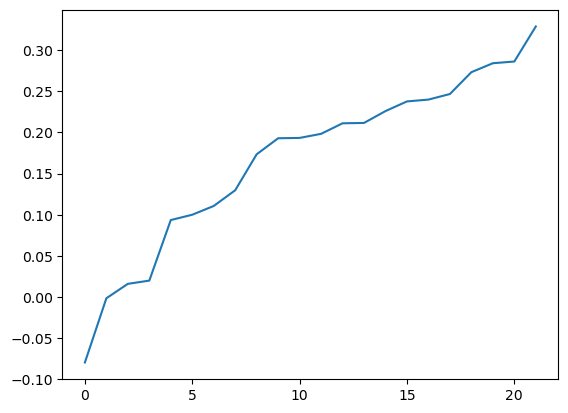

timestamp                  symbol
2022-09-10 12:00:00+00:00  ADA      -0.111111
                           ATOM     -0.111111
                           BNB      -0.111111
                           BTC       0.000000
                           DOT      -0.111111
                                       ...   
2022-11-09 12:00:00+00:00  ETH       0.168924
                           LINK      0.123452
                           MATIC     0.125628
                           SOL       0.252310
                           XRP       0.154608
Name: position, Length: 14410, dtype: float32
['ADA', 'ATOM', 'BNB', 'BTC', 'DOT', 'ETH', 'LINK', 'MATIC', 'SOL', 'XRP']
test shift predict


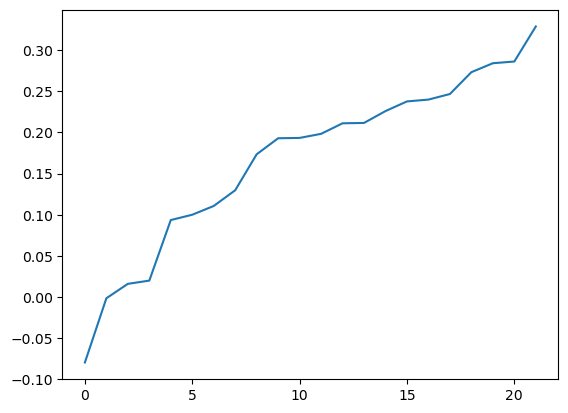

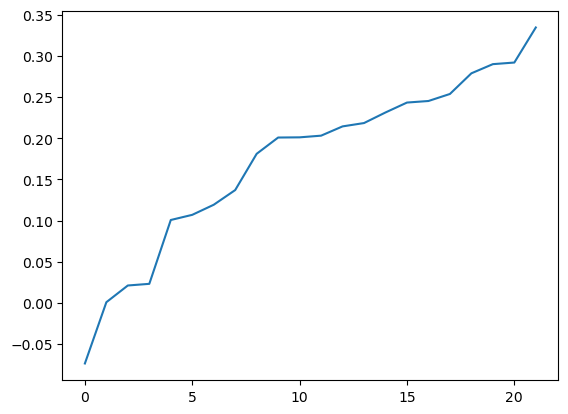

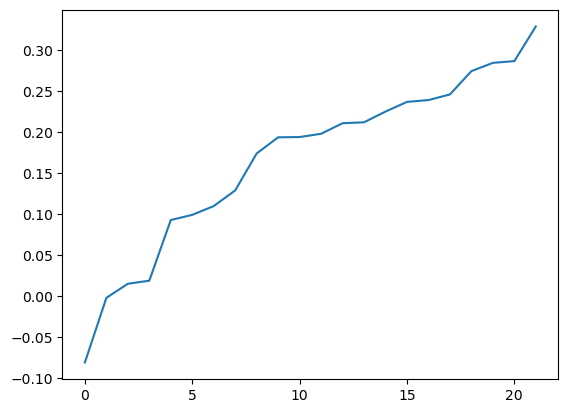

position1  position2  position3
timestamp                 symbol                                 
2022-09-10 13:00:00+00:00 ADA     -0.111111  -0.111111  -0.111111
                          ATOM    -0.111111  -0.111111  -0.111111
                          BNB     -0.111111  -0.111111  -0.111111
                          BTC      0.000000   0.000000   0.000000
                          DOT     -0.111111  -0.111111  -0.111111
...                                     ...        ...        ...
2022-11-09 11:00:00+00:00 ETH      0.190069   0.190069   0.190069
                          LINK     0.129424   0.129424   0.129424
                          MATIC    0.136680   0.136680   0.136680
                          SOL      0.218091   0.218091   0.218091
                          XRP      0.170106   0.170106   0.170106

[14390 rows x 3 columns]

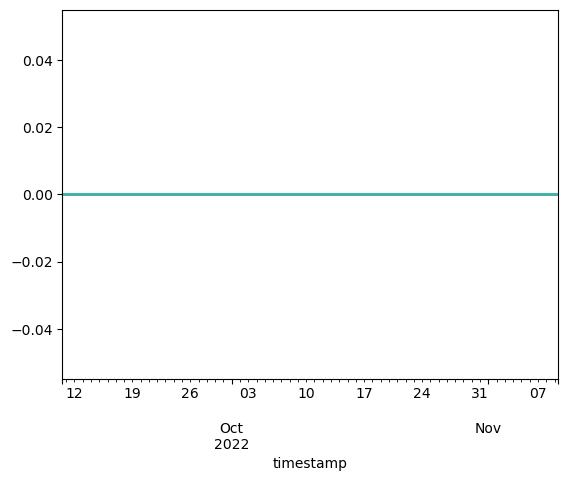

ADA (1439, 4)
ATOM (1439, 4)
BNB (1439, 4)
BTC (1439, 4)
DOT (1439, 4)
ETH (1439, 4)
LINK (1439, 4)
MATIC (1439, 4)
SOL (1439, 4)
XRP (1439, 4)


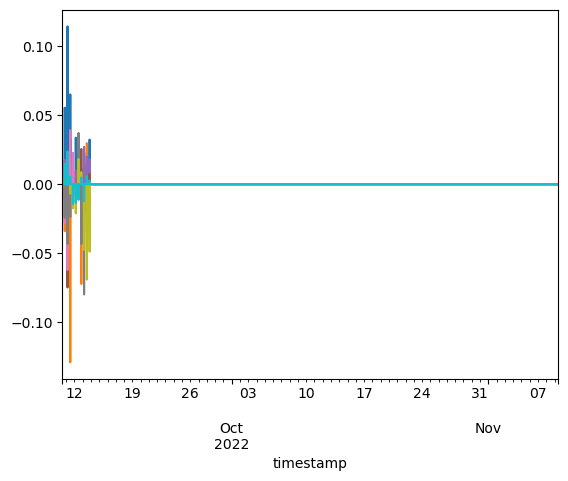

In [12]:
# model validation (Just run this cell in the new kernel to make sure you saved it in a portable format.)

import os
import joblib
import pandas as pd

model = joblib.load('/home/jovyan/data/20221028_btc_one_cnn_h8.xz')
df = pd.read_pickle('/tmp/df_horizon8_price_type_none.pkl')
df = df[['op', 'hi', 'lo', 'cl', 'volume']]
max_timestamp = df.index.get_level_values('timestamp').max()
df = df.loc[max_timestamp - pd.to_timedelta(model.max_data_sec, unit='S') <= df.index.get_level_values('timestamp')]
print(model.predict(df))
print(model.symbols)



print('test shift predict')
import matplotlib.pyplot as plt

position1 = model.predict(df)
position2 = model.predict(df.loc[df.index.get_level_values('timestamp') < max_timestamp])
position3 = model.predict(df.loc[df.index.get_level_values('timestamp').min() < df.index.get_level_values('timestamp')])

test_timestamp = max_timestamp - pd.to_timedelta(1, unit='H')
df_test = pd.concat([
    position1.rename('position1'),
    position2.rename('position2'),
    position3.rename('position3'),
], axis=1)

df_test = df_test.dropna()
display(df_test)

for symbol, df_symbol in df_test.groupby('symbol'):
    df_symbol = df_symbol.reset_index().set_index('timestamp')
    (df_symbol['position2'] - df_symbol['position1']).plot()
plt.show()

for symbol, df_symbol in df_test.groupby('symbol'):
    df_symbol = df_symbol.reset_index().set_index('timestamp')
    print(symbol, df_symbol.shape)
    (df_symbol['position3'] - df_symbol['position1']).plot()
plt.show()